In [1]:
import yt
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm
from matplotlib import colormaps
import scipy
import pandas as pd
import os
import glob
from astropy.cosmology import FlatLambdaCDM
import pickle

In [2]:
# def _mean_molecular_weight2(field, data):
#     return data['ramses', "xHI"] - data['ramses', "xHII"]

# yt.add_field(
#     ('gas', "mu_new"),
#     sampling_type="local",
#     function=_mean_molecular_weight2,
#     units="",
# )

In [3]:
g2Msun = 1./1.9891e33
kpc2cm = 3.086e21
Myr2s = (303*31536000+97*31622400)/400*1e6  # Gregorian calendar: 400 year cycle of 303 common years + 97 leap years.

kB     = 1.3806200e-16          # Boltzmann constant [erg/K]

mH     = 1.6735575e-24          # Hydrogen atom mass [g]

RamsesDir = '/minkewhale/kimm/rey/G8_normal/SINK_9pc'
# RamsesDir = '/minkewhale/mrey/outputs/00204'
timestep = 203

In [4]:
def read_info(RamsesDir, timestep, alt_path=None):
    """ Returns info from the simulation (dict). """
    #savepath = get_alt_path(RamsesDir, alt_path=alt_path)
    #check_ratapath(savepath)
    savepath = RamsesDir
    path_info = f'{savepath}/ratadat/info_dict.pkl'
    if not os.path.exists(path_info):                # If first time, save general data
        info_dict = read_info_glob(RamsesDir, timestep=timestep)
        with open(path_info, 'wb') as file: 
            pickle.dump({'00000': info_dict}, file)
    with open(path_info, 'rb') as file:              # Otherwise, load common data
        all_info = pickle.load(file)
        info_dict = all_info.get('00000', {}).copy() # Important to copy, otherwise '00000' will be modified
        if timestep != 0:
            t_group = f'{timestep:05d}'
            if t_group in all_info:                  # And add timestep specific data.
                info_dict = all_info[t_group]
            else:
                info_dict = read_info_tstep(RamsesDir, timestep, info_dict)
                all_info[t_group] = info_dict
                with open(path_info, 'wb') as file:
                    pickle.dump(all_info, file)
    return info_dict


def read_info_glob(RamsesDir, timestep=1):
    """ Read info parameters common to all timesteps of a given simulation. """
    tstep = f'{timestep:05d}'
    path_out = f'{RamsesDir}/output_{tstep}/'
    
    # Initialise some variables which might not be defined.
    info_dict = {}
    info_dict['new_format'] = get_format(f'{path_out}header_{tstep}.txt')                     # Get whether post-2017 or not
    for key in ['isH2', 'delayed_cooling', 'momentum_feedback']:
        info_dict[key] = False

    # Namelist
    info_dict  = param2dict(info_dict, get_nml(RamsesDir, timestep))                                    # Namelist
    info_dict  = param2dict(info_dict, f'{path_out}info_rt_{tstep}.txt')                                # info_rt_xxxxx.txt
    info_dict  = hydro2dict(info_dict, f'{path_out}hydro_file_descriptor.txt', info_dict['new_format']) # hydro_file_descriptor
    info_dict  = get_nvar  (info_dict, path_out, tstep)                                                 # (after hydro2dict)

    # Corrections
    info_dict['X_fraction'] = round(info_dict['X_fraction'], 6) # Correct precision error in info_rt_xxxxx.txt
    info_dict['Y_fraction'] = round(info_dict['Y_fraction'], 6)

    # Determine simulation type
    # Note: original way is the following BUT have to read info_xxxxx.txt (resp header_xxx.txt), and some variables there depends on timestep
    #       info_dict['is_cosmo'] = info_dict['omega_m']!=1.0 and info_dict['aexp']!=1 and info_dict['H0']!=1 
    #       info_dict['is_zoom']  = info_dict['is_cosmo'] and info_dict['ndm'] != (2*info_dict['levelmin'])*info_dict['ndim']
    info_dict['is_cosmo'] = info_dict['cosmo']
    info_dict['is_zoom']  = info_dict['is_cosmo'] and 'initfile(2)' in info_dict
    info_dict['is_cool_refine'] = 'cooling_refine' in info_dict and any(value != -1 for value in info_dict['cooling_refine'])
    info_dict['nvarnoadvect'] = info_dict['cooling_time_ivar'] if info_dict['is_cool_refine'] else 0

    return info_dict


def read_info_tstep(RamsesDir, timestep, info_dict):
    """ Read info parameters for a given timestep anc add some units. """
    tstep = f'{timestep:05d}'
    path_out = f'{RamsesDir}/output_{tstep}/'
    info_dict  = param2dict(info_dict, f'{path_out}info_{tstep}.txt')               # info_xxxxx.txt
    info_dict  = headr2dict(info_dict, f'{path_out}header_{tstep}.txt', info_dict['new_format']) # header_xxxxx.txt

    # Units
    info_dict['unit_m']      = info_dict['unit_d']*info_dict['unit_l']**3
    info_dict['unit_v']      = info_dict['unit_l']/info_dict['unit_t']
    info_dict['unit_P']      = info_dict['unit_d']*info_dict['unit_v']**2
    info_dict['unit_T2']     = mH/kB*info_dict['unit_v']**2
    info_dict['unit_nH']     = info_dict['X_fraction']*info_dict['unit_d']/mH
    info_dict['unit_nHe']    = info_dict['unit_nH'] * info_dict['Y_fraction']/info_dict['X_fraction'] * 0.25
    info_dict['cu2cm']       = info_dict['unit_l'] * info_dict['boxlen']
    info_dict['boxlen_cMpc'] = info_dict['boxlen']*info_dict['unit_l']/info_dict['aexp']/kpc2cm/1e3 if info_dict['is_cosmo'] else None
    info_dict['redshift']    = 1./info_dict['aexp']-1
    info_dict['t_myr']       = info_dict['time']*info_dict['unit_t']/Myr2s if not info_dict['is_cosmo']\
        else FlatLambdaCDM(H0=info_dict['H0'],Om0=info_dict['omega_m']).age(1/info_dict['aexp']-1).value*1e3
    return info_dict


def get_nml(RamsesDir, timestep):
    """Return the path to the nml."""
    # Check the output directory
    path_nml = f'{RamsesDir}/output_{timestep:05d}/namelist.txt'    
    if os.access(path_nml, os.R_OK):            # Check it's readable
        with open(path_nml, 'r') as file:
            for line in file:
                if '&RUN_PARAMS' in line:       
                    return path_nml
    # If the file is doesn't exist/is corrupted, check the RamsesDir
    nml_files = glob.glob(f"{RamsesDir}/*.nml")
    path_nml = next((f for f in nml_files if os.access(f, os.R_OK)), None) # First nml with read access
    if path_nml is None:
        raise Exception(f"No accessible .nml file found in {RamsesDir}.")
    return path_nml


def headr2dict(info_dict, file_path, new_format):
    """ Add header variables (i.e. number of particles and particle fields) to info_dict. """
    header = {
        "Total number of particles": "npart",       # Old format
        "Total number of dark matter particles": "ndm",
        "Total number of star particles": "nstar",
        "Total number of sink particles": "nsink",
        "DM": "ndm",                                # New format
        "star": "nstar",
    }
    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()
            if "Particle fields" in line:
                info_dict["particle_fields"] = next(file).strip().split()
                break  # No more info after particle fields
            parts = line.split()
            if new_format and len(parts) == 2 and parts[0] in header:
                info_dict[header[parts[0]]] = int(parts[1])
            elif not new_format and 'Total' in line:
                info_dict[header[line]] = int(next(file).strip())
    return info_dict


def hydro2dict(info_dict, path_hydrofd, new_format):
    """ Read hydro_file_descriptor and add the indexes of the hydro parameters to info_dict. """
    with open(path_hydrofd, 'r') as file:
        for line in file:
            line = line.strip()
            if not line.startswith('#'): # skip the first in new format
                parts = line.split(',') if new_format else line.replace('#', ':').split(':')
                index1, index2 = (0, 1) if new_format else (-2, -1)
                if len(parts) >= 2:
                    info_dict[parts[index2].strip()] = int(parts[index1].strip())
    rename_map = {
        'density': 'idens',
        'velocity_x': 'ivel',
        'thermal_pressure': 'iPT',
        'pressure': 'iPT'
    }
    for old_name, new_name in rename_map.items():
        if old_name in info_dict:
            info_dict[new_name] = info_dict.pop(old_name)
    return info_dict


def get_nvar(info_dict, path_out, tstep):
    """ Try to get nvar from hydro_xxxxx.out00001, and in the hydro_file_descriptor if it fails. 
        First option is favoured as the hydro_file_descriptor can be badly coded. """
    hydro_file = f'{path_out}hydro_{tstep}.out00001'
    if os.path.exists(hydro_file):          # Try to read hydro_xxxxx.out00001
        with open(f'{path_out}hydro_{tstep}.out00001', 'rb') as f:  
            info_dict['nvar'] = np.fromfile(f, dtype=np.int32, count=5)[4]
    elif not 'dm' in path_out.lower():      # Else, skip if DM-only simulation and take the highest value from the hydro_file_descriptor.
        info_dict['nvar'] = info_dict[max((key for key in info_dict if 'scalar_' in key), key=lambda x: int(x.rsplit('_', 1)[1]), default=None)]
    return info_dict
def get_ramses_index(info, include_rt=False):                                                         # TODO: CR, MHD
    """ 
    Determine the index of the variables in the ramses output.
    """
    # Variables obtained in info
    dict_index = {'Density':       info['idens'],
                  'x-velocity':       info['ivel'],
                  'y-velocity':       info['ivel']+1                    if info['ndim']>=2 else None,
                  'z-velocity':       info['ivel']+2                    if info['ndim']>=3 else None,
                  'Pressure':        info['iPT']+info['rt_isIRtrap'],
                  'Metallicity':        info['iPT']+info['rt_isIRtrap']+1 if info['metal']   else None,
                  'xHI':      info['iIons']                     if info['isH2']    else None,
                  'xHII':     info['iIons']+info['isH2']        if info['rt']      else None,
                  'xHeII':    info['iIons']+info['isH2']+1      if info['rt']      else None,
                  'xHeIII':   info['iIons']+info['isH2']+2      if info['rt']      else None,
                }

    # Additional variables
    counter = info['iPT'] + info['rt_isIRtrap'] + info['metal'] + info['nIons']  # info['isH2'] already counted in nIons
    if info['delayed_cooling']:   dict_index['DC_var'],         counter = counter + 1, counter + 1  # delayed cooling
    if info['momentum_feedback']: dict_index['KR_turb'],        counter = counter + 1, counter + 1  # patch mom2 by Kretschmer
    if info['is_zoom']:           dict_index['zoom_var'],       counter = counter + 1, counter + 1  # zoom-in simulations
    if info['is_cool_refine']:    dict_index['cooling_length'], counter = counter + 1, counter + 1  # cooling length refinement

    # RT variables: N_photons and flux_nx/y/z for each group n.
    if info['rt'] and include_rt:
        for i in range(1, info['nGroups'] + 1):
            dict_index[f'N_photons{i}'] = info['nvar'] + 1 + (i - 1) * 4 if info['nGroups'] >= i else None
            for axis in ['x', 'y', 'z']:
                dict_index[f'flux_{i}{axis}'] = info['nvar'] + 2 + "xyz".index(axis) + (i - 1) * 4 if info['nGroups'] >= i else None

    return dict_index

def get_values(var, dictionary):    # TODO: restrict to one value, not T or temperature. Then, remove this function -> everything will be more readable.
    """ Helper function to be able to format dictionary keys as tuples. """
    for key in dictionary:
        if var in key:
            return dictionary[key]
    return None


def get_format(path_hdr):
    """ Returns whether the code is formatted following RAMSES post-2017 or not. """
    with open(path_hdr, 'r') as file:
        first_line = file.readline().strip()
        if 'Total number of particles' in first_line: return False
        elif '#      Family     Count' in first_line: return True
        else: raise ValueError("Unrecognized header format.")


def fort2py(value):
    """ Convert Fortran values to Python. """
    if value.lower() in ('.true.', '.false.'):  return value.lower() == '.true.'    # Booleans
    elif (value.startswith("'") and value.endswith("'")): return value[1:-1]        # Strings
    else:
        try: return float(value) if 'e' in value or '.' in value else int(value)    # Numerals
        except ValueError:  return value                                            # Other strings


def param2dict(info_dict, path_file):
    """ General function to get parameters from a file and add them to a dictionary. """
    with open(path_file, 'r') as file:
        for line in file:
            line = line.split('!')[0].strip()       # Remove comments and whitespace
            if '=' in line:
                key, value = map(str.strip, line.split('='))
                if key!='movie_vars_txt':           # Replace 'd' with 'e' for float compatibility
                    value = value.replace('d', 'e')
                if ',' in value or '*' in value:    # Convert lists
                    value_list = []
                    for element in value.split(','):
                        if '*' in element:
                            count, val = element.split('*')
                            value_list.extend([int(float(val.strip()))] * int(count))
                        else:
                            value_list.append(fort2py(element.strip()))
                    value = value_list
                else:
                    value = fort2py(value)          # Convert single values
                info_dict[key] = value
            elif "DOMAIN" in line or "Photon group properties" in line:
                break
    return info_dict

In [5]:
info = read_info(RamsesDir, 203)
dict_index = get_ramses_index(info)
print(dict_index)
#fields = list(dict_index.keys())       to add in instead of field_handler.py when we get derived fields too.

{'Density': 1, 'x-velocity': 2, 'y-velocity': 3, 'z-velocity': 4, 'Pressure': 5, 'Metallicity': 6, 'xHI': 7, 'xHII': 8, 'xHeII': 9, 'xHeIII': 10}


#   Here loads the data, choosing a specific time-step from the directory.

In [6]:
#Loads the data
extra_particle_fields = [("particle_birth_time", "float64"), ("particle_metallicity", "float64"), ("particle_imass", "float64")]
    #extra fields included in the data that yt does not automatically detect (I assume to save time?)
center_dat=[0.5, 0.5, 0.5]
rad_dat = 0.2739726724728318
bbox = [[c-rad_dat for c in center_dat], [c+rad_dat for c in center_dat]]
ds = yt.load(f'{RamsesDir}/output_{timestep:05d}', extra_particle_fields=extra_particle_fields, fields = list(dict_index.keys()))
ad = ds.all_data() #apparently required to put all data into a readable way.

yt : [INFO     ] 2024-10-04 18:53:42,607 Parameters: current_time              = 33.8554226025076
yt : [INFO     ] 2024-10-04 18:53:42,607 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2024-10-04 18:53:42,608 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-10-04 18:53:42,608 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2024-10-04 18:53:42,609 Parameters: cosmological_simulation   = 0


('gas', 'deposit', 'index', 'gravity', 'ramses-rt', 'ramses')
case1
['Density', 'x-velocity', 'y-velocity', 'z-velocity', 'Pressure', 'Metallicity', 'xHI', 'xHII', 'xHeII', 'xHeIII']


yt : [WARNING  ] 2024-10-04 18:53:44,174 This cooling file format is no longer supported. Cooling field loading skipped.


In [9]:
print(ds.parameter_filename)

/minkewhale/kimm/rey/G8_normal/SINK_9pc/output_00203/info_00203.txt


In [8]:
RamsesDir = '/minkewhale/kimm/rey/G8_normal/SINK_9pc'
# RamsesDir = '/minkewhale/mrey/outputs/00204'
timestep = 203
# ds = yt.load('/minkewhale/mrey/outputs/00204')
ds = yt.load('/minkewhale/kimm/rey/G8_normal/SINK_9pc/output_00203')



yt : [INFO     ] 2024-10-04 18:05:53,441 Parameters: current_time              = 33.8554226025076
yt : [INFO     ] 2024-10-04 18:05:53,441 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2024-10-04 18:05:53,442 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-10-04 18:05:53,442 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2024-10-04 18:05:53,442 Parameters: cosmological_simulation   = 0


In [42]:
print(np.sum(ad[('gas', 'cell_mass')].in_units('Msun'))+np.sum(ad[('io', 'particle_mass')].in_units('Msun')))
print(np.sum(ad[('io', 'particle_mass')].in_units('Msun')))

271896133.7572919 Msun
10242189920.886608 Msun


yt : [INFO     ] 2024-10-02 19:20:09,855 xlim = 0.000000 1.000000
yt : [INFO     ] 2024-10-02 19:20:09,856 ylim = 0.000000 1.000000
yt : [INFO     ] 2024-10-02 19:20:09,859 xlim = 0.000000 1.000000
yt : [INFO     ] 2024-10-02 19:20:09,860 ylim = 0.000000 1.000000
yt : [INFO     ] 2024-10-02 19:20:09,860 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800
yt : [INFO     ] 2024-10-02 19:20:10,308 Saving plot face.PNG_Slice_z_density.png



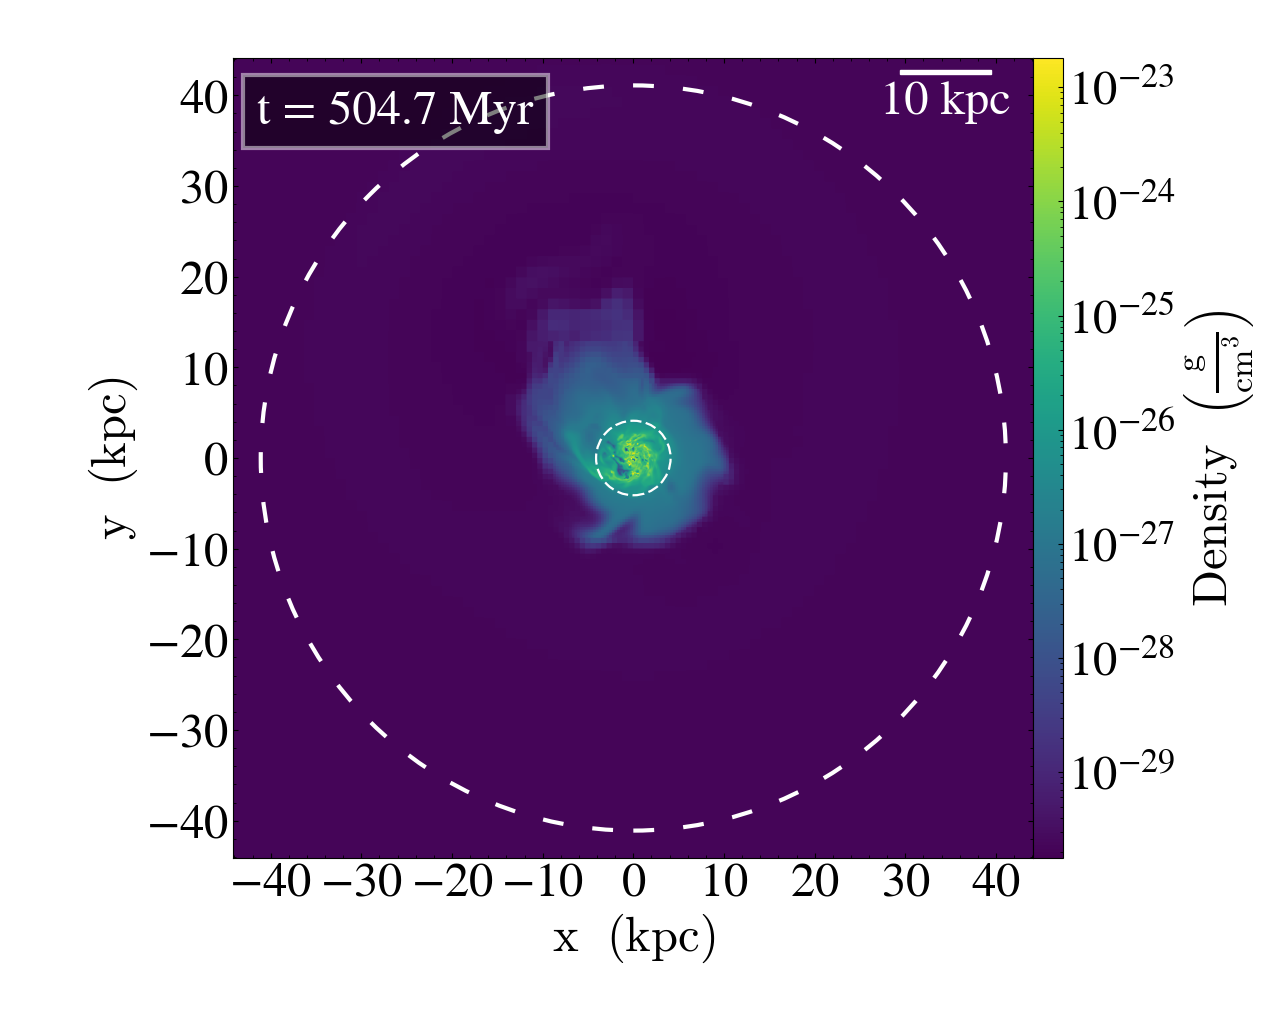

yt : [INFO     ] 2024-10-02 19:20:11,258 xlim = 0.000000 1.000000
yt : [INFO     ] 2024-10-02 19:20:11,259 ylim = 0.000000 1.000000
yt : [INFO     ] 2024-10-02 19:20:11,261 xlim = 0.000000 1.000000
yt : [INFO     ] 2024-10-02 19:20:11,262 ylim = 0.000000 1.000000
yt : [INFO     ] 2024-10-02 19:20:11,262 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800
yt : [INFO     ] 2024-10-02 19:20:11,664 Saving plot edge.PNG_Slice_x_density.png



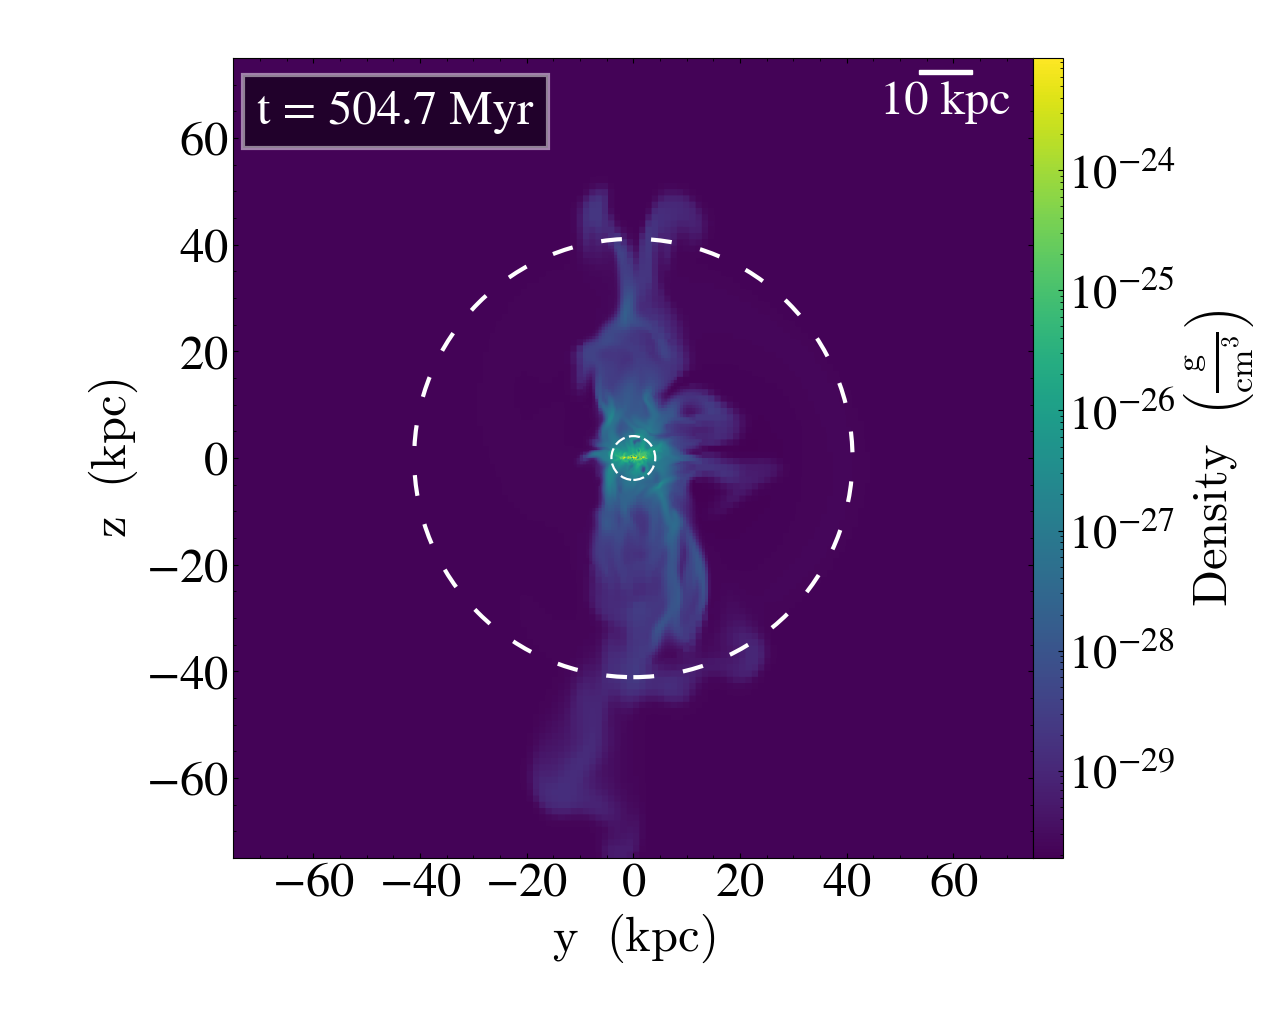

In [39]:
#Slice plots, over z=0, with the normal being the z axis (plot x-y plane)
slice_density = yt.SlicePlot(ds, 'z', ("gas", "density"), fontsize = 35)
slice_density.set_cmap(("gas", "density"), "viridis") #Change colormaps
slice_density.annotate_timestamp(corner="upper_left", redshift=False, draw_inset_box=True)
slice_density.annotate_scale(corner="upper_right")
slice_density.annotate_sphere([0.5, 0.5, 0.5], radius=(41.0959, "kpc"), circle_args = {'linestyle':(0, (5, 7)), 'linewidth':3})
slice_density.annotate_sphere([0.5, 0.5, 0.5], radius=(4.10959, "kpc"), circle_args = {'linestyle':(0, (5, 2)), 'linewidth':1.6})
slice_density.zoom(1.7)
slice_density.save('face.PNG')
slice_density.show()

slice_density = yt.SlicePlot(ds, 'x', ("gas", "density"), fontsize = 35)
slice_density.set_cmap(("gas", "density"), "viridis") #Change colormaps
slice_density.annotate_timestamp(corner="upper_left", redshift=False, draw_inset_box=True)
slice_density.annotate_scale(corner="upper_right")
slice_density.annotate_sphere([0.5, 0.5, 0.5], radius=(41.0959, "kpc"), circle_args = {'linestyle':(0, (5, 7)), 'linewidth':3})
slice_density.annotate_sphere([0.5, 0.5, 0.5], radius=(4.10959, "kpc"), circle_args = {'linestyle':(0, (5, 2)), 'linewidth':1.6})
slice_density.zoom(1)
slice_density.save('edge.PNG')
slice_density.show()
# slice_temperature = yt.SlicePlot(ds, 'x', ("gas", "temperature_mu"))
# slice_temperature.set_cmap(("gas", "temperature_mu"), "seismic")
# slice_temperature.zoom(4)
# slice_temperature.show()

yt : [INFO     ] 2024-10-04 16:11:26,128 xlim = 0.000000 1.000000
yt : [INFO     ] 2024-10-04 16:11:26,129 ylim = 0.000000 1.000000
yt : [INFO     ] 2024-10-04 16:11:26,131 xlim = 0.000000 1.000000
yt : [INFO     ] 2024-10-04 16:11:26,131 ylim = 0.000000 1.000000
yt : [INFO     ] 2024-10-04 16:11:26,132 Making a fixed resolution buffer of (('gas', 'radial_velocity')) 800 by 800



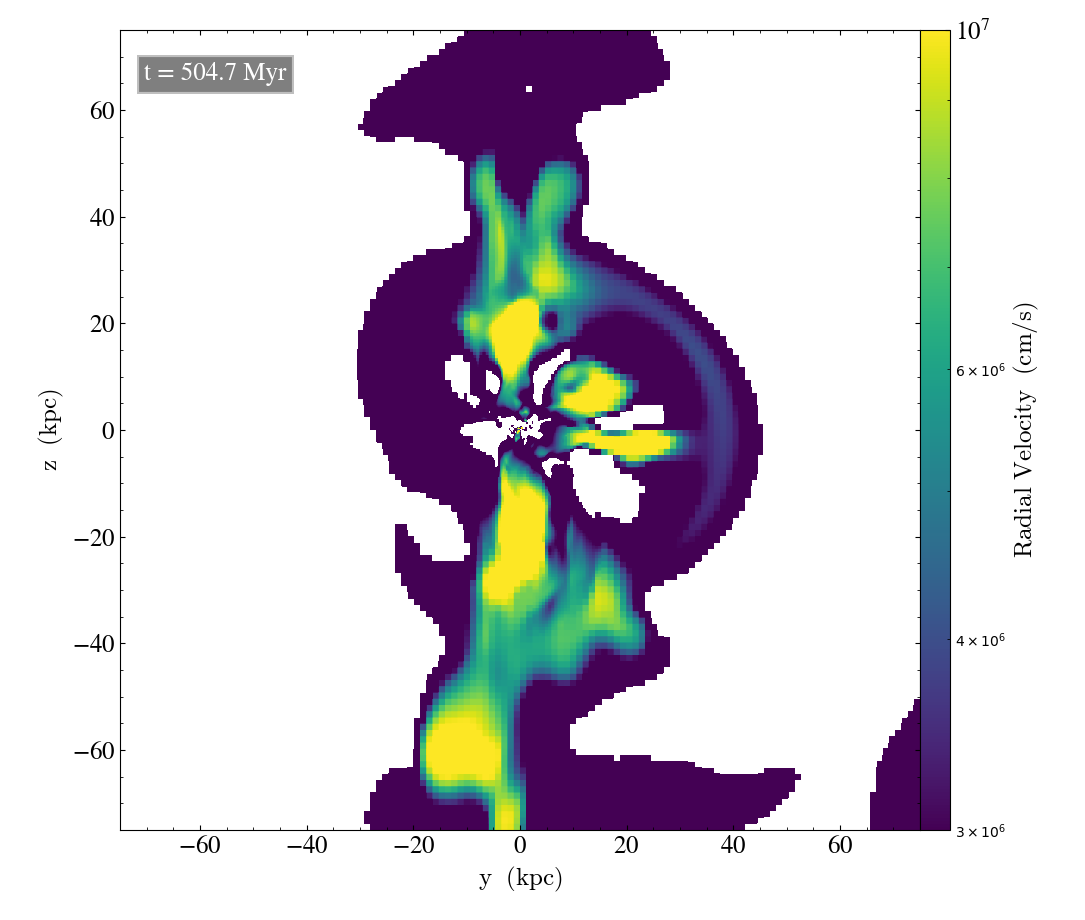

In [11]:
#Slice plots, over z=0, with the normal being the z axis (plot x-y plane)
slice_density = yt.SlicePlot(ds, 'x', ("gas", "radial_velocity"))
slice_density.set_cmap(("gas", "radial_velocity"), "viridis") #Change colormaps
slice_density.annotate_timestamp(corner="upper_left", redshift=False, draw_inset_box=True)
slice_density.annotate_scale(corner="upper_right")
slice_density.set_zlim('radial_velocity', 3e6, 1e7)
slice_density.zoom(1)
slice_density.show()


# slice_temperature = yt.SlicePlot(ds, 'x', ("gas", "temperature"))
# slice_temperature.set_cmap(("gas", "temperature"), "seismic")
# slice_temperature.zoom(4)
# slice_temperature.show()

In [8]:
print(dict_index)

{'Density': 1, 'x-velocity': 2, 'y-velocity': 3, 'z-velocity': 4, 'Pressure': 5, 'Metallicity': 6, 'xHI': 7, 'xHII': 8, 'xHeII': 9, 'xHeIII': 10}


In [9]:
print('\n'.join(str(field) for field in ds.derived_field_list  if field[0]=='gas'))

('gas', 'acceleration_x')
('gas', 'acceleration_y')
('gas', 'acceleration_z')
('gas', 'angular_momentum_magnitude')
('gas', 'angular_momentum_x')
('gas', 'angular_momentum_y')
('gas', 'angular_momentum_z')
('gas', 'averaged_density')
('gas', 'baroclinic_vorticity_magnitude')
('gas', 'baroclinic_vorticity_x')
('gas', 'baroclinic_vorticity_y')
('gas', 'baroclinic_vorticity_z')
('gas', 'cell_mass')
('gas', 'cell_volume')
('gas', 'courant_time_step')
('gas', 'cutting_plane_velocity_x')
('gas', 'cutting_plane_velocity_y')
('gas', 'cutting_plane_velocity_z')
('gas', 'density')
('gas', 'density_2')
('gas', 'density_gradient_magnitude')
('gas', 'density_gradient_x')
('gas', 'density_gradient_y')
('gas', 'density_gradient_z')
('gas', 'dx')
('gas', 'dy')
('gas', 'dynamical_time')
('gas', 'dz')
('gas', 'four_velocity_magnitude')
('gas', 'four_velocity_t')
('gas', 'four_velocity_x')
('gas', 'four_velocity_y')
('gas', 'four_velocity_z')
('gas', 'jeans_mass')
('gas', 'kT')
('gas', 'kinetic_energy_de

In [8]:
ds.derived_field_list

[('deposit', 'io_cic'),
 ('deposit', 'io_cic_age'),
 ('deposit', 'io_cic_velocity_x'),
 ('deposit', 'io_cic_velocity_y'),
 ('deposit', 'io_cic_velocity_z'),
 ('deposit', 'io_count'),
 ('deposit', 'io_density'),
 ('deposit', 'io_mass'),
 ('deposit', 'io_nn_age'),
 ('deposit', 'io_nn_velocity_x'),
 ('deposit', 'io_nn_velocity_y'),
 ('deposit', 'io_nn_velocity_z'),
 ('deposit', 'nbody_cic'),
 ('deposit', 'nbody_cic_age'),
 ('deposit', 'nbody_cic_velocity_x'),
 ('deposit', 'nbody_cic_velocity_y'),
 ('deposit', 'nbody_cic_velocity_z'),
 ('deposit', 'nbody_count'),
 ('deposit', 'nbody_density'),
 ('deposit', 'nbody_mass'),
 ('deposit', 'nbody_nn_age'),
 ('deposit', 'nbody_nn_velocity_x'),
 ('deposit', 'nbody_nn_velocity_y'),
 ('deposit', 'nbody_nn_velocity_z'),
 ('deposit', 'sink_cic'),
 ('deposit', 'sink_cic_age'),
 ('deposit', 'sink_cic_velocity_x'),
 ('deposit', 'sink_cic_velocity_y'),
 ('deposit', 'sink_cic_velocity_z'),
 ('deposit', 'sink_count'),
 ('deposit', 'sink_density'),
 ('deposi

Accessing data

In [9]:
#This is how you access a certain field of data: the array of all particle initial masses
imass = ad[("io", "particle_mass")].in_units('g')
temp = ad[("gas", "temperature")] 
pos = ad[('gas', 'z')]
print(np.max(imass))
print(np.max(temp))
print(np.max(pos))

1.9971558549999995e+38 g
149885531.75425404 K
4.610436229845176e+23 cm


In [11]:
mu = ad[('gas', 'mu')]

In [10]:
T_mu = ad['gas', 'temperature_mu']
temps = ad['gas', 'temperature']

YTFieldNotFound: Could not find field ('gas', 'temperature_mu') in info_00203.

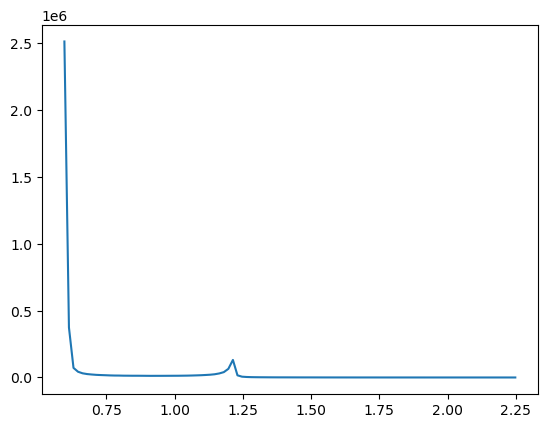

In [13]:
hist, bin_edges = np.histogram(mu, bins = 100)
bin_centers = (bin_edges[:-1]+bin_edges[1:])/2
plt.plot(bin_centers, hist)
#plt.xscale('log')
#plt.yscale('log')

#   Plotting Stuffs

yt : [INFO     ] 2024-09-19 18:46:30,325 xlim = 0.000000 1.000000
yt : [INFO     ] 2024-09-19 18:46:30,325 ylim = 0.000000 1.000000
yt : [INFO     ] 2024-09-19 18:46:30,327 xlim = 0.000000 1.000000
yt : [INFO     ] 2024-09-19 18:46:30,328 ylim = 0.000000 1.000000
yt : [INFO     ] 2024-09-19 18:46:30,328 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800



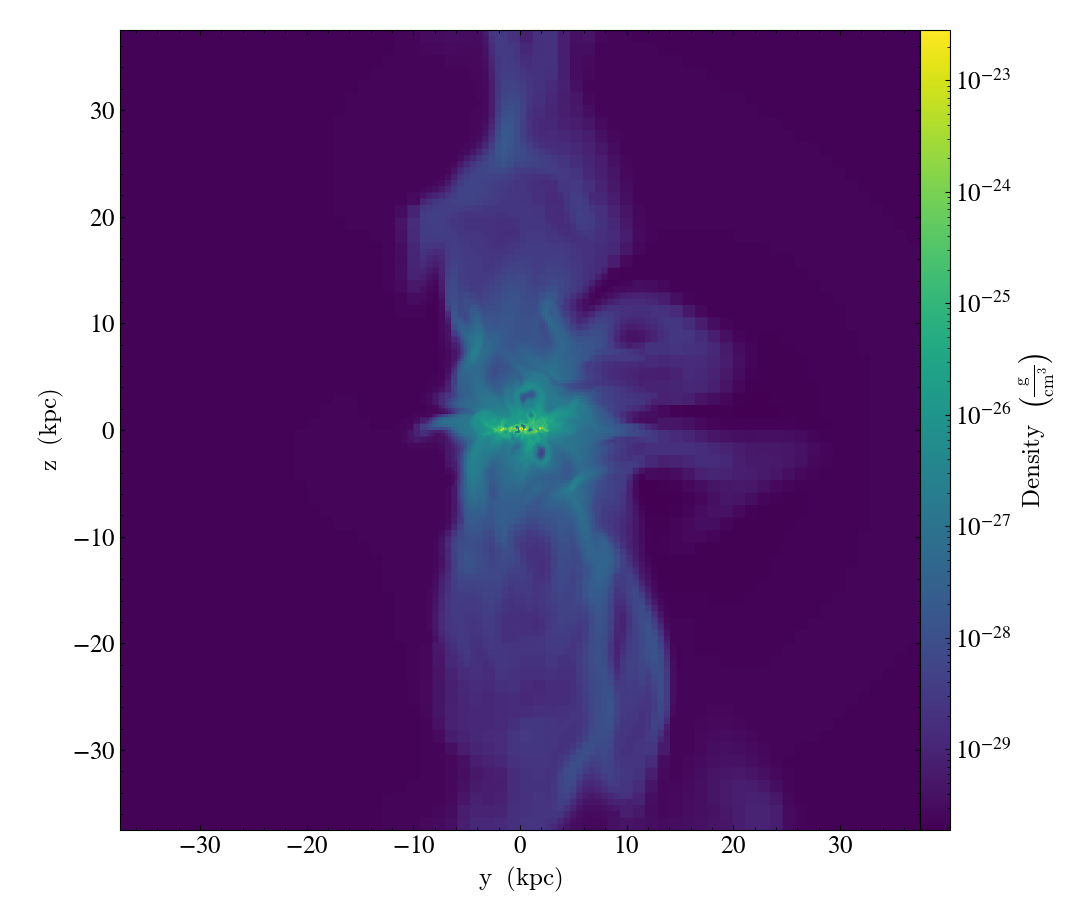

yt : [INFO     ] 2024-09-19 18:46:31,290 xlim = 0.000000 1.000000
yt : [INFO     ] 2024-09-19 18:46:31,291 ylim = 0.000000 1.000000
yt : [INFO     ] 2024-09-19 18:46:31,292 xlim = 0.000000 1.000000
yt : [INFO     ] 2024-09-19 18:46:31,293 ylim = 0.000000 1.000000
yt : [INFO     ] 2024-09-19 18:46:31,294 Making a fixed resolution buffer of (('gas', 'temperature')) 800 by 800



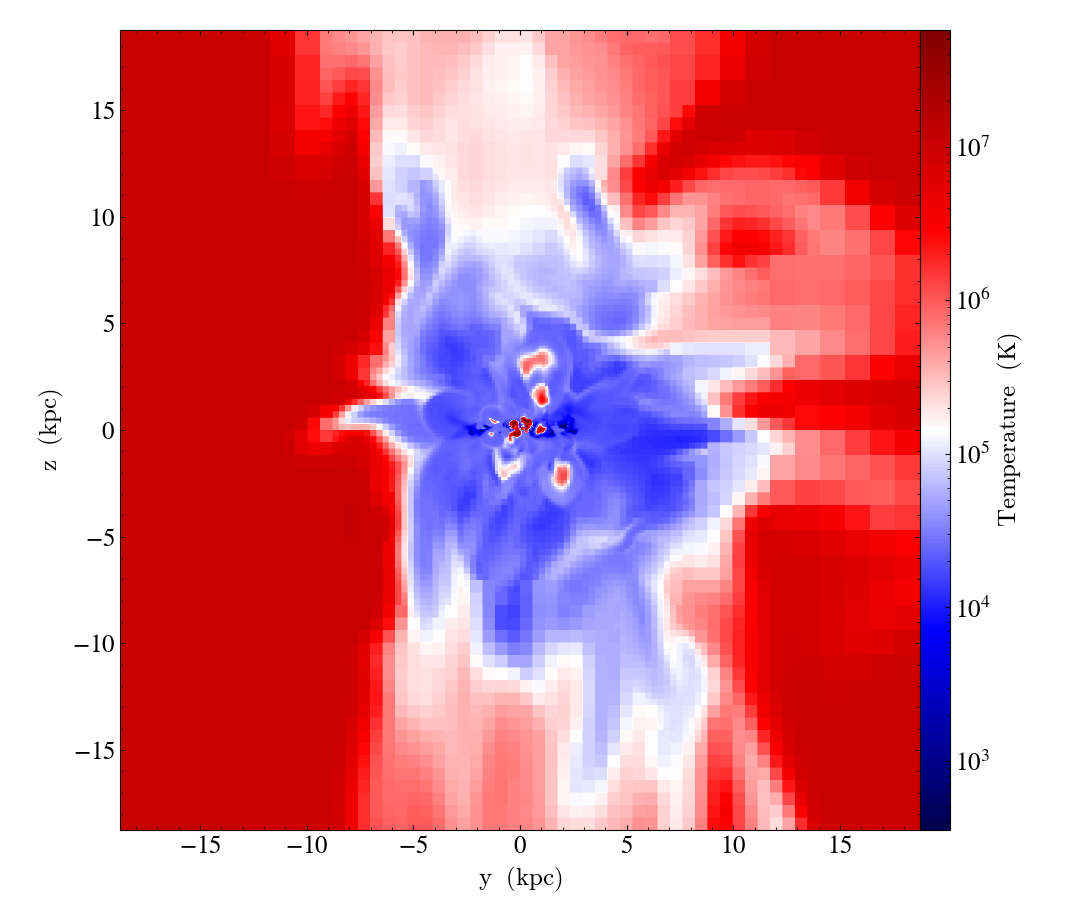

In [25]:
#Slice plots, over z=0, with the normal being the z axis (plot x-y plane)
slice_density = yt.SlicePlot(ds, 'x', ("gas", "density"))
slice_density.set_cmap(("gas", "density"), "viridis") #Change colormaps
slice_density.zoom(2)
slice_density.show()
slice_density.annotate_timestamp(corner="upper_left", redshift=False, draw_inset_box=True)
slice_density.annotate_scale(corner="upper_right")

slice_temperature = yt.SlicePlot(ds, 'x', ("gas", "temperature"))
slice_temperature.set_cmap(("gas", "temperature"), "seismic")
slice_temperature.zoom(4)
slice_temperature.show()

In [8]:
print(ad['gas', 'dz'].in_units('pc'))

[1171.87500012 1171.87500012 1171.87500012 ...  146.48437502  146.48437502
  146.48437502] pc


yt : [INFO     ] 2024-09-19 22:52:10,123 xlim = 0.000000 1.000000
yt : [INFO     ] 2024-09-19 22:52:10,124 ylim = 0.000000 1.000000
yt : [INFO     ] 2024-09-19 22:52:10,125 xlim = 0.000000 1.000000
yt : [INFO     ] 2024-09-19 22:52:10,126 ylim = 0.000000 1.000000
yt : [INFO     ] 2024-09-19 22:52:10,127 Making a fixed resolution buffer of (('gas', 'density_2')) 800 by 800
yt : [INFO     ] 2024-09-19 22:52:10,743 Saving plot aahh.png



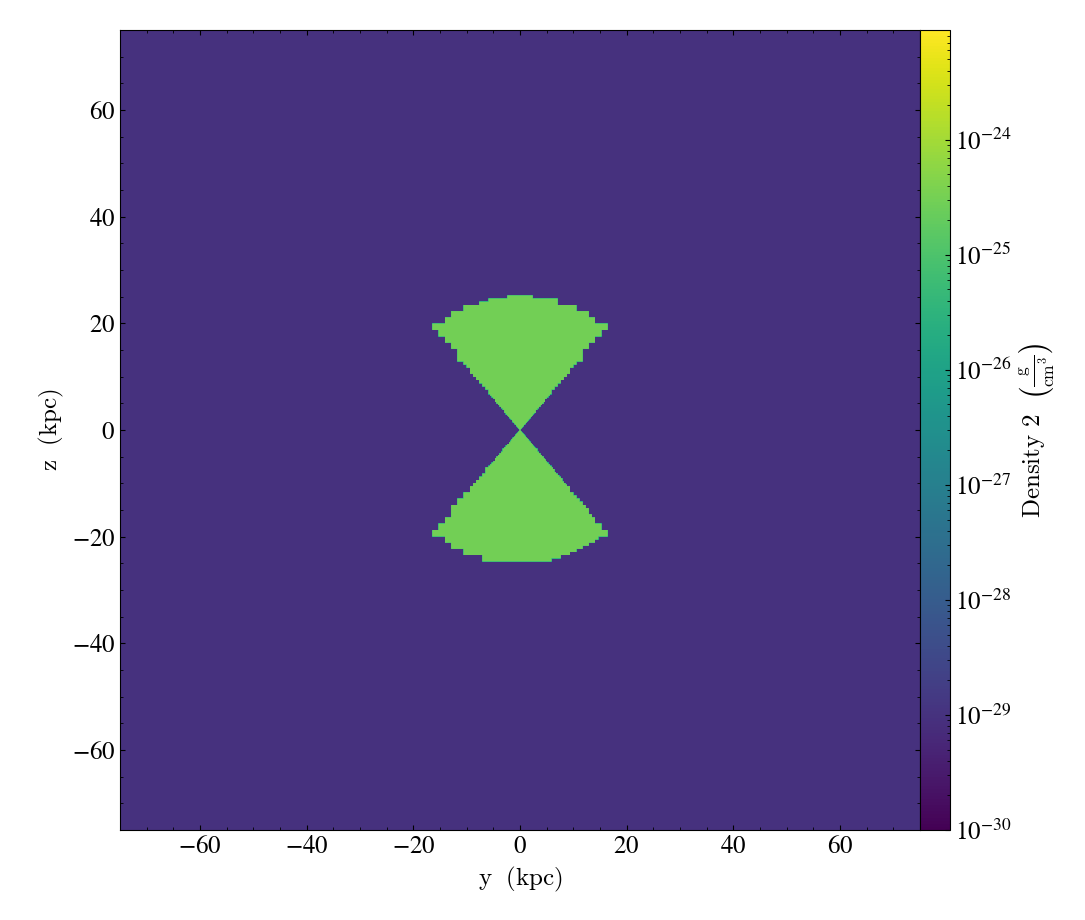

yt : [INFO     ] 2024-09-19 22:52:11,305 xlim = 0.000000 1.000000
yt : [INFO     ] 2024-09-19 22:52:11,306 ylim = 0.000000 1.000000
yt : [INFO     ] 2024-09-19 22:52:11,307 xlim = 0.000000 1.000000
yt : [INFO     ] 2024-09-19 22:52:11,308 ylim = 0.000000 1.000000
yt : [INFO     ] 2024-09-19 22:52:11,309 Making a fixed resolution buffer of (('gas', 'temperature_mu')) 800 by 800



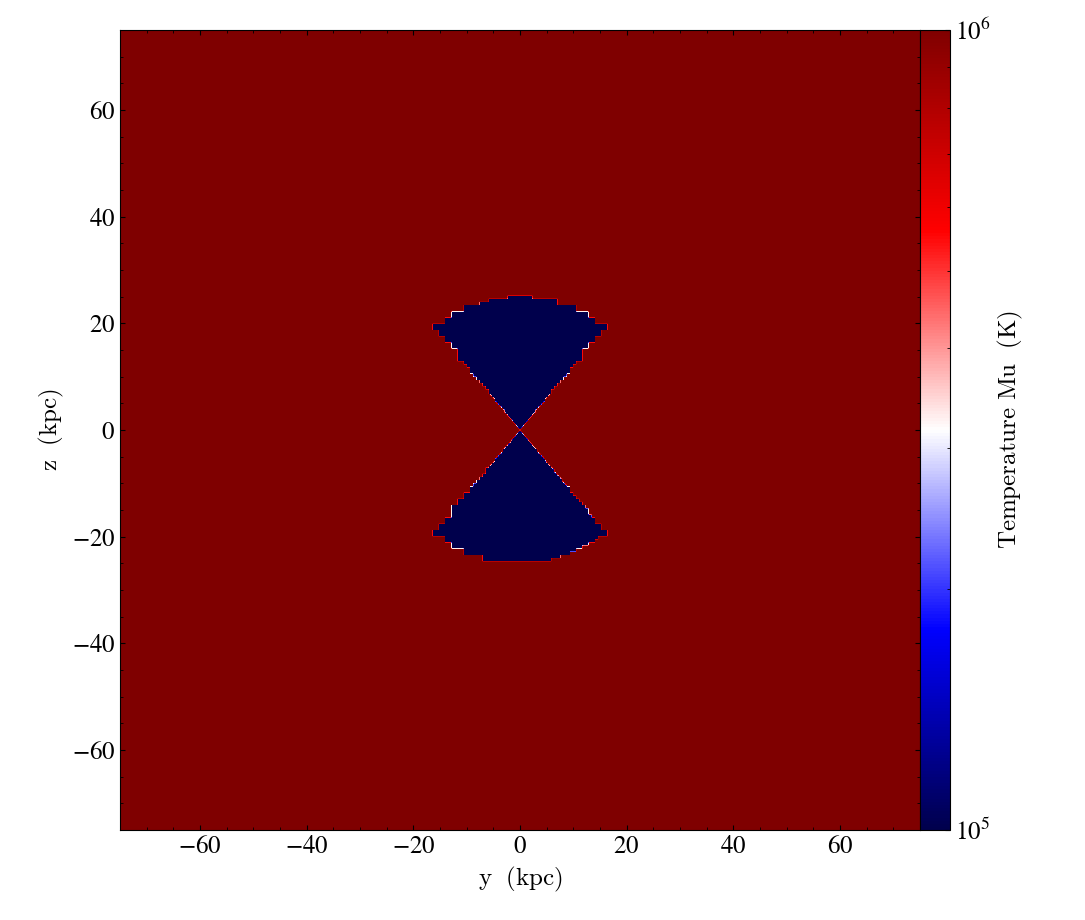

yt : [INFO     ] 2024-09-19 22:52:12,638 xlim = 0.000000 1.000000
yt : [INFO     ] 2024-09-19 22:52:12,639 ylim = 0.000000 1.000000
yt : [INFO     ] 2024-09-19 22:52:12,641 xlim = 0.000000 1.000000
yt : [INFO     ] 2024-09-19 22:52:12,641 ylim = 0.000000 1.000000
yt : [INFO     ] 2024-09-19 22:52:12,642 Making a fixed resolution buffer of (('gas', 'radial_velocity')) 800 by 800



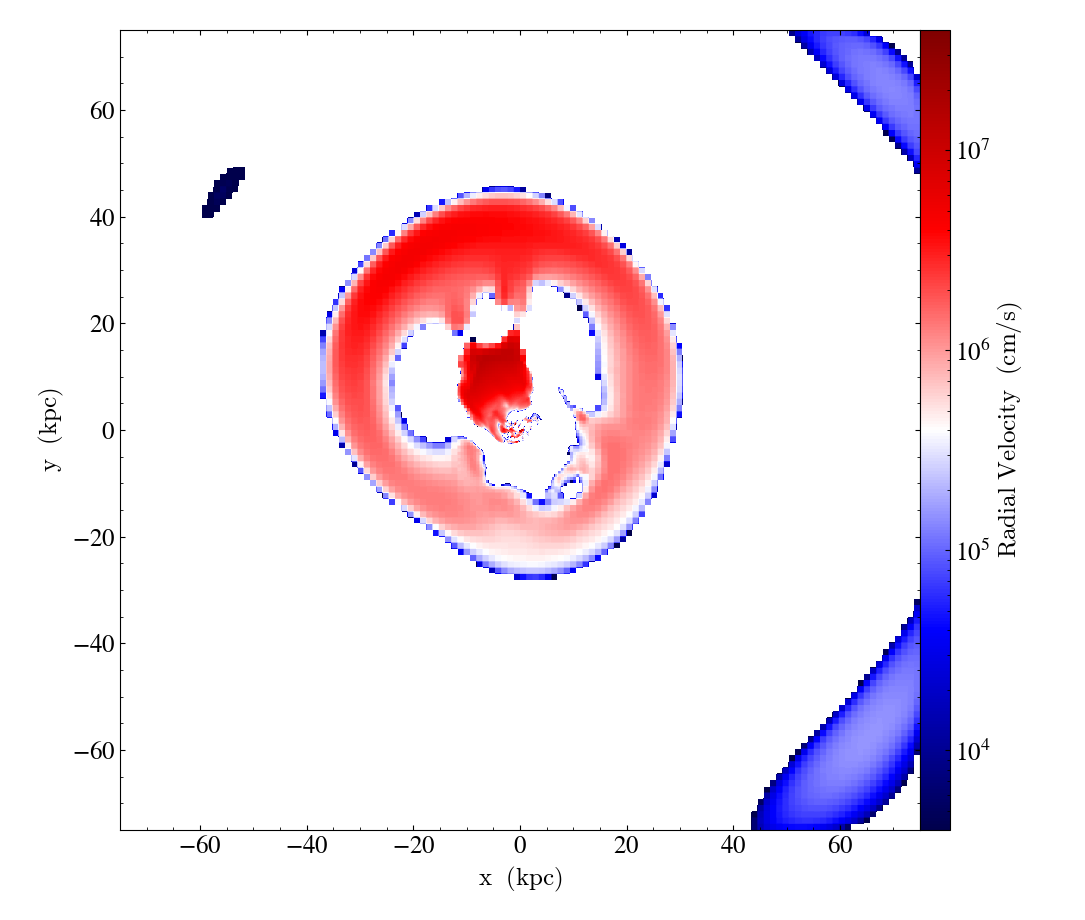

In [87]:
#Projection along an axis, you can look up other variations of this for more freedom (ie OffAxis, etc)
projection_density = yt.SlicePlot(ds, 'x', ("gas", "density_2"))
projection_density.set_cmap(("gas", "density_2"), "viridis")
projection_density.zoom(1)
projection_density.set_zlim('density_2', 1e-30, 9e-24)
projection_density.save('aahh.png')
projection_density.show()

projection_density = yt.SlicePlot(ds, 'x', ("gas", "temperature_mu"))
projection_density.set_cmap(("gas", "temperature_mu"), "seismic")
projection_density.zoom(1)
projection_density.show()

projection_temperature = yt.SlicePlot(ds, 'z', ("gas", "radial_velocity"))
projection_temperature.set_cmap(("gas", "radial_velocity"), "seismic")
projection_temperature.zoom(1)
projection_temperature.set_zlim('radial_velocity', 4e3, 4e7)
projection_temperature.show()

In [47]:
rho = 5e-26
Temp = 3e5
vel = 7000*1000

def _temperature_mu_2(field, data):
    theta = data['index', 'spherical_theta']
    r = data['index', 'spherical_radius'].in_units('kpc')
    rv = data['gas', 'temperature'].in_units('K').value
    if len(np.shape(theta)) == 1:
        mask = ((theta > 2.44) | (theta < 0.698)) & ((r < 35))
        rv = np.where(mask, Temp, 1e6)
    return yt.YTArray(rv, 'K')
def _density_2(field, data):
    theta = data['index', 'spherical_theta']
    r = data['index', 'spherical_radius'].in_units('kpc')
    rv = data['gas', 'density'].in_units('g/cm**3').value
    def den(r):
        return rho/(r**2)
    if len(np.shape(theta)) == 1:
        mask = ((theta > 2.44) | (theta < 0.698)) & ((r < 35) & (r > 0))
        rv = np.where(mask, den(r), 1e-29)
    return yt.YTArray(rv, 'g/cm**3')
def _vel(field, data):
    theta = data['index', 'spherical_theta']
    r = data['index', 'spherical_radius'].in_units('kpc')
    rv = data['gas', 'radial_velocity'].in_units('cm/s').value
    v_rad = vel
    if len(np.shape(theta)) == 1:
        mask = ((theta > 2.44) | (theta < 0.698)) & ((r < 35))
        rv = np.where(mask, v_rad, rv)
    return yt.YTArray(rv, 'cm/s')

ds.add_field(
    ("gas", "density_2"),
    sampling_type="cell",
    function=_density_2,
    units='g/cm**3',
    force_override = True
)
ds.add_field(
    ("gas", "temperature_mu"),
    sampling_type="cell",
    function=_temperature_mu_2,
    units='K',
    force_override = True
)
ds.add_field(
    ("gas", "vel_rad"),
    sampling_type="cell",
    function=_vel,
    units='cm/s',
    force_override = True
)

In [48]:
np.max(ds.all_data()[('gas', 'z')].in_units('kpc'))

unyt_quantity(149.41406252, 'kpc')

yt : [INFO     ] 2024-09-20 00:04:08,067 xlim = 0.000000 1.000000
yt : [INFO     ] 2024-09-20 00:04:08,067 ylim = 0.000000 1.000000
yt : [INFO     ] 2024-09-20 00:04:08,069 xlim = 0.000000 1.000000
yt : [INFO     ] 2024-09-20 00:04:08,069 ylim = 0.000000 1.000000
yt : [INFO     ] 2024-09-20 00:04:08,070 Making a fixed resolution buffer of (('gas', 'density_2')) 800 by 800
yt : [INFO     ] 2024-09-20 00:04:08,483 Saving plot aahh.png



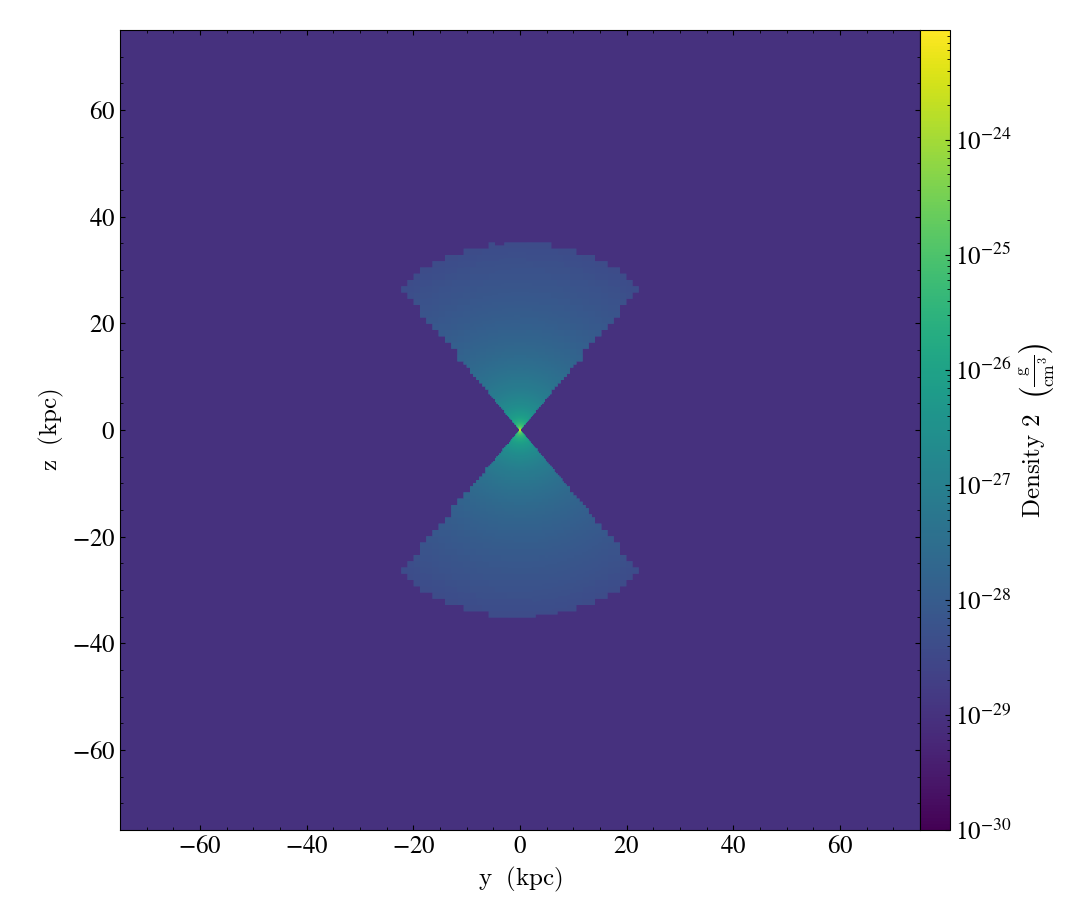

yt : [INFO     ] 2024-09-20 00:04:09,042 xlim = 0.000000 1.000000
yt : [INFO     ] 2024-09-20 00:04:09,043 ylim = 0.000000 1.000000
yt : [INFO     ] 2024-09-20 00:04:09,044 xlim = 0.000000 1.000000
yt : [INFO     ] 2024-09-20 00:04:09,045 ylim = 0.000000 1.000000
yt : [INFO     ] 2024-09-20 00:04:09,046 Making a fixed resolution buffer of (('gas', 'temperature_mu')) 800 by 800



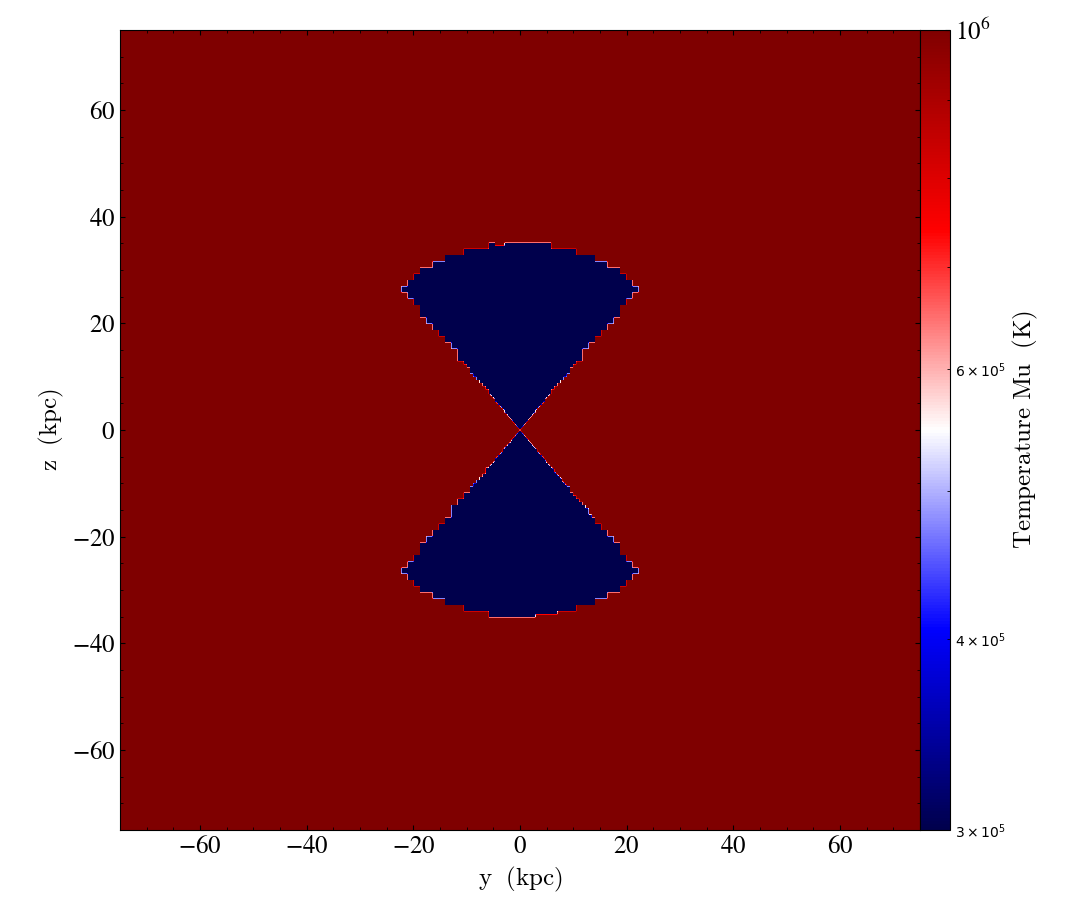

yt : [INFO     ] 2024-09-20 00:04:09,680 xlim = 0.000000 1.000000
yt : [INFO     ] 2024-09-20 00:04:09,681 ylim = 0.000000 1.000000
yt : [INFO     ] 2024-09-20 00:04:09,683 xlim = 0.000000 1.000000
yt : [INFO     ] 2024-09-20 00:04:09,683 ylim = 0.000000 1.000000
yt : [INFO     ] 2024-09-20 00:04:09,684 Making a fixed resolution buffer of (('gas', 'vel_rad')) 800 by 800



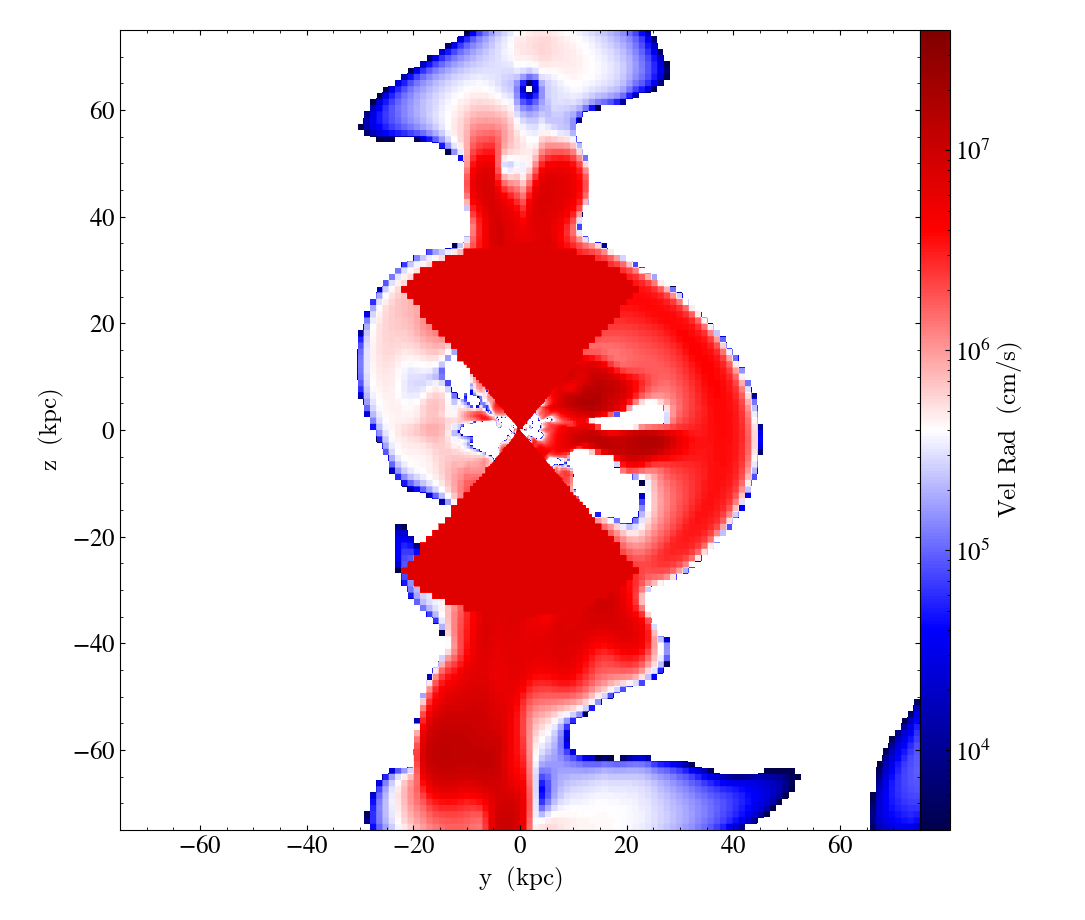

In [49]:
#Projection along an axis, you can look up other variations of this for more freedom (ie OffAxis, etc)
projection_density = yt.SlicePlot(ds, 'x', ("gas", "density_2"))
projection_density.set_cmap(("gas", "density_2"), "viridis")
projection_density.zoom(1)
projection_density.set_zlim('density_2', 1e-30, 9e-24)
projection_density.save('aahh.png')
projection_density.show()

projection_density = yt.SlicePlot(ds, 'x', ("gas", "temperature_mu"))
projection_density.set_cmap(("gas", "temperature_mu"), "seismic")
projection_density.zoom(1)
projection_density.show()

projection_temperature = yt.SlicePlot(ds, 'x', ("gas", "vel_rad"))
projection_temperature.set_cmap(("gas", "vel_rad"), "seismic")
projection_temperature.zoom(1)
projection_temperature.set_zlim('vel_rad', 4e3, 4e7)
projection_temperature.show()

yt : [INFO     ] 2024-09-19 21:23:40,766 max value is 3.17468e-21 at 0.5116882324218750 0.4929504394531250 0.5013122558593750
yt : [INFO     ] 2024-09-19 21:23:42,030 Projection completed
yt : [INFO     ] 2024-09-19 21:23:42,032 Making a fixed resolution buffer of (('gas', 'density')) 1000 by 1000


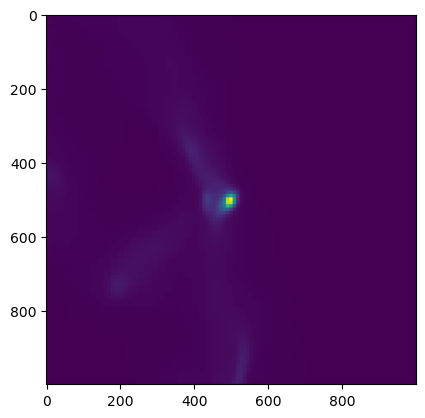

In [55]:
#Playing with FRB
_, c = ds.find_max(("gas", "density"))

proj = ds.proj(('gas', 'density'), axis = 'z')
frb = proj.to_frb((1, 'kpc'), [1000, 1000], c)

plt.imshow(np.array(frb["gas", "density"]))
plt.show()

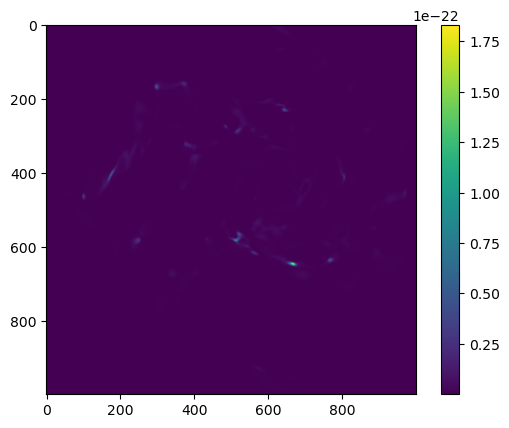

In [13]:
#More FRB, example copied from documentation
slc = ds.slice("z", 0.5)
frb = slc.to_frb((5, "kpc"), 1000, c)
#frb.apply_gauss_beam(nbeam=30, sigma=2.0)
#frb.apply_white_noise(5e-23)
im = plt.imshow(frb["gas", "density"].d)
plt.colorbar(im)
plt.show()


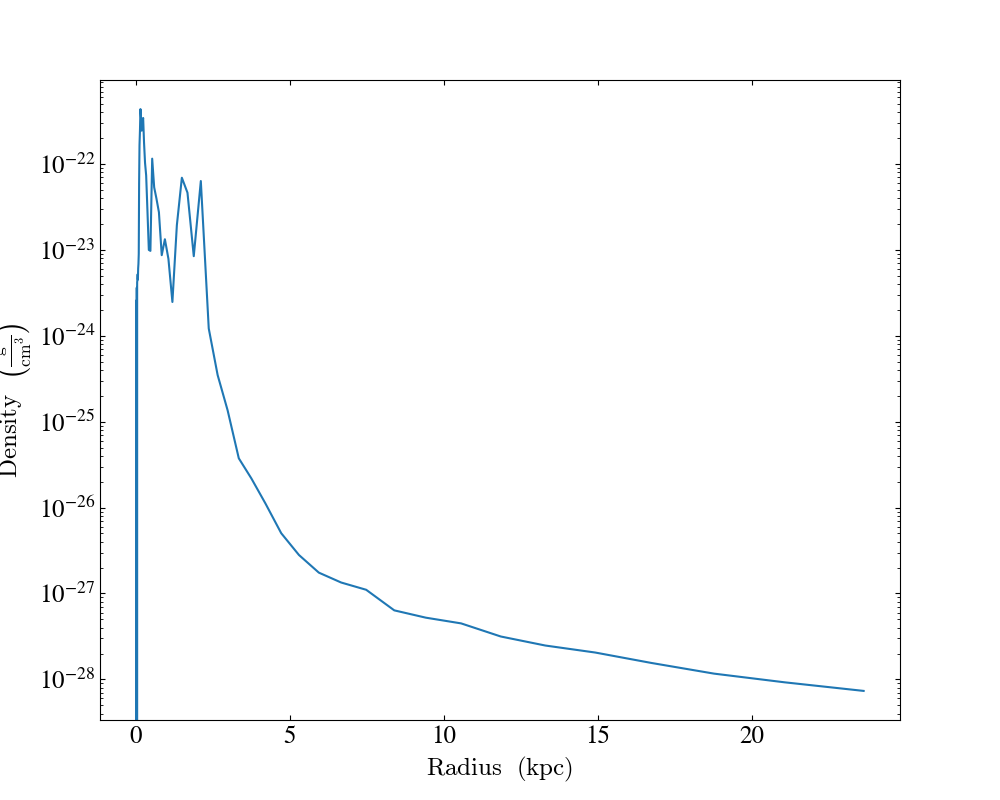

In [8]:
#Create Radial profile
# Creating a sphere object by selecting points from ds, think of it as making a new ds (dataset) only using the selected data
sp = ds.sphere([0.5, 0.5, 0.5], (25, "kpc"))

#creating a profile of the galaxy: how its temperature vary with distance from centre.
plot_temp = yt.ProfilePlot(sp, ("gas", "radius"), ("gas", "density"))
plot_temp.set_unit(("gas", "radius"), "kpc")
plot_temp.set_log(("gas", "radius"), False)
plot_temp.set_log(("gas", "density"), True)
plot_temp.show()

yt : [INFO     ] 2024-07-19 20:35:24,872 xlim = 0.000000 1.000000
yt : [INFO     ] 2024-07-19 20:35:24,873 ylim = 0.000000 1.000000
yt : [INFO     ] 2024-07-19 20:35:24,875 xlim = 0.000000 1.000000
yt : [INFO     ] 2024-07-19 20:35:24,876 ylim = 0.000000 1.000000
yt : [INFO     ] 2024-07-19 20:35:24,877 Making a fixed resolution buffer of (('gas', 'temperature')) 800 by 800
/home/chiyu/miniconda3/lib/python3.12/site-packages/unyt/array.py:1803: RuntimeWarning: divide by zero encountered in log10
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)



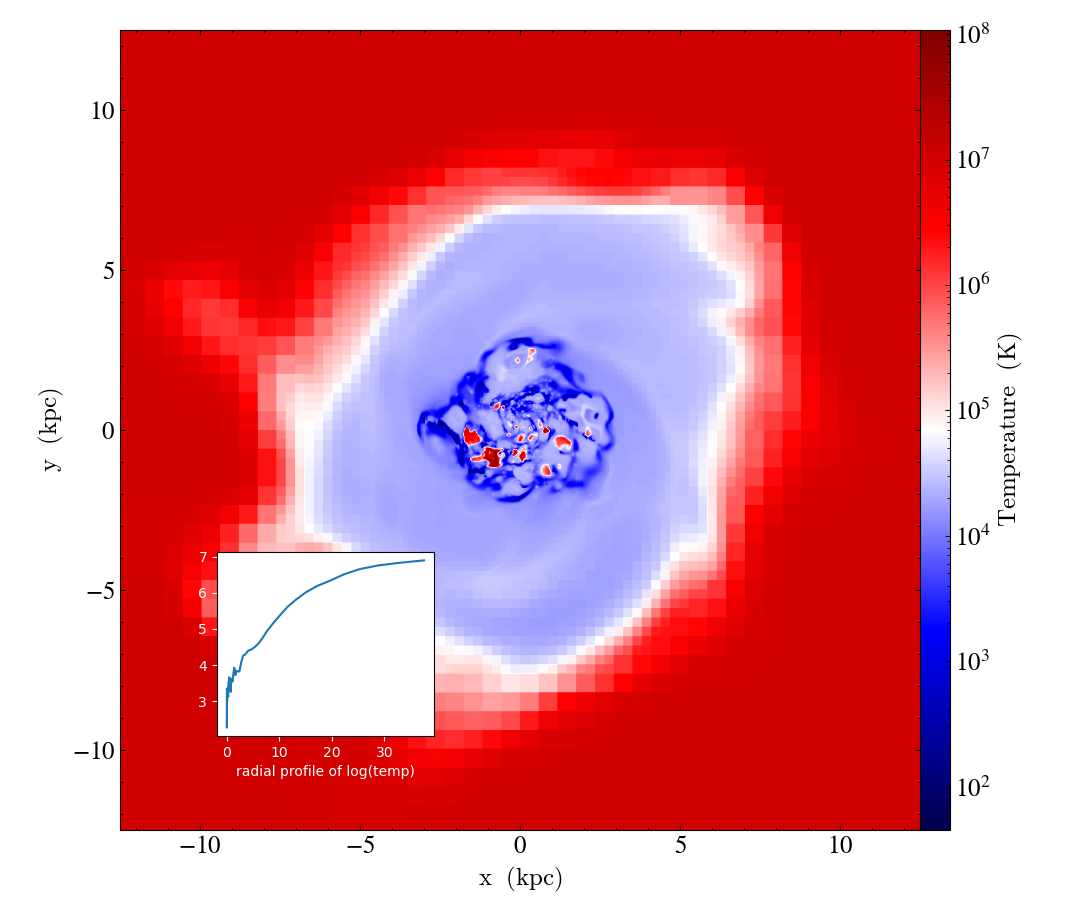

In [15]:
#Playing with making subplots and whatever
slice_temperature = yt.SlicePlot(ds, 'z', ("gas", "temperature"))
slice_temperature.set_cmap(("gas", "temperature"), "seismic")
slice_temperature.zoom(6)
ax = slice_temperature.plots[("gas", "temperature")].axes
fig = slice_temperature.plots[("gas", "temperature")].figure

#
#   yt.create_profile just returns the lists of x.value and whatever profile you want (VERY USEFUL!!!!!!!!!)
rp = yt.create_profile(sp, ("index", "radius"), ("gas", "temperature"), units = {("index", "radius"): "kpc"})
rect = (0.2, 0.2, 0.2, 0.2) #(pos, pos, size, size)
new_ax = fig.add_axes(rect)
new_ax.plot(rp.x.value, np.log10(rp[("gas", "temperature")])) #Note syntax
new_ax.tick_params(colors = 'white')
new_ax.set_xlabel("radial profile of log(temp)").set_color("white")

slice_temperature.show()

Trying to create a  phase diagram weighted by mass

In [16]:
#defining the temperature and density as their logs for nicer plotting
temps = np.log10(ad[("gas", "temperature")])
den = np.log10(ad[("gas", "density")])
mass = ad[("gas", "mass")]
mass_total = np.sum(mass)
print(np.max(temps), np.min(temps))
print(np.max(den), np.min(den))
print(np.log10(np.max(mass/(2e33))), np.log10(np.min(mass/(2e33))))

8.209534318864327 1.004552866003434
-20.216818249038703 -30.363072690975265
4.835217350155162 -3.2135512491463762


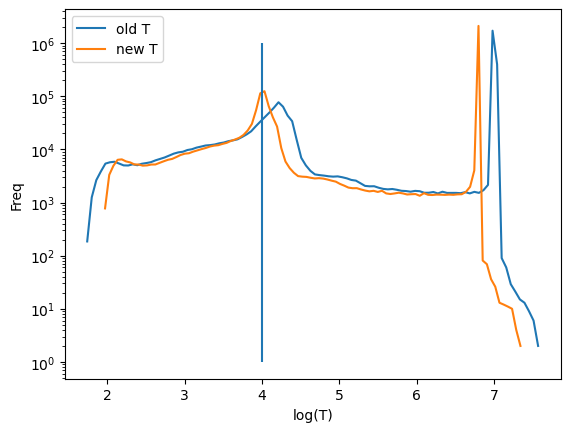

In [11]:
#Creating a PDF for the temperature of the galaxy
hist, bin_edges = np.histogram(np.log10(temps), bins = 100)
hist2, bin_edges2 = np.histogram(np.log10(T_mu), bins = 100)
bin_centers = (bin_edges[:-1] + bin_edges[1:])/2
bin_centers2 = (bin_edges2[:-1] + bin_edges2[1:])/2
plt.plot(bin_centers, hist)
plt.plot(bin_centers2, hist2)
plt.vlines(4, 1, 1e6)
plt.legend(('old T', 'new T'))
plt.xlabel('log(T)')
plt.ylabel('Freq')
plt.yscale('log')


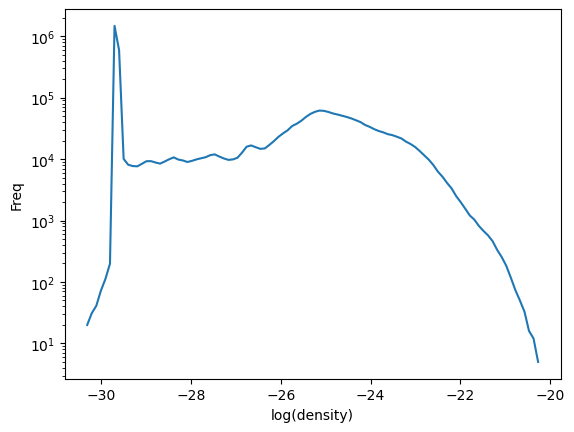

In [18]:
#Creating a PDF for the density of the galaxy
hist, bin_edges = np.histogram(den, bins = 100)
bin_centers = (bin_edges[:-1] + bin_edges[1:])/2
plt.plot(bin_centers, hist)
plt.xlabel('log(density)')
plt.ylabel('Freq')
plt.yscale('log')

Where the 2d Histograms are, they are Weighted by mass using numpy

In [19]:
histW, xedgesW, yedgesW = np.histogram2d(temps, den, bins = 300, range = [[ 1, 9 ], [ -32, -20 ]], weights = np.log10(mass/(2e23)))
#print(xedges, yedges)

Text(0, 0.5, 'log(density)')

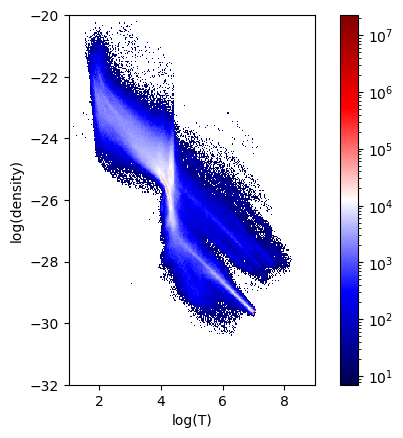

In [20]:
im = plt.imshow(histW.T, interpolation='nearest', origin = 'lower', norm = LogNorm(), extent=[xedgesW[0],xedgesW[-1],yedgesW[0],yedgesW[-1]], cmap='seismic')
#im = plt.pcolormesh(XW, YW, histW)
plt.colorbar(im)
plt.xlabel("log(T)")
plt.ylabel("log(density)")
#plt.xlim(0,250)
#plt.xscale("log")
#plt.yscale('log')

Let's play with particles now instead of gas

In [25]:
mass_par = ad[("io", "particle_mass")]

yt : [INFO     ] 2024-07-19 20:35:33,858 xlim = 0.000000 1.000000
yt : [INFO     ] 2024-07-19 20:35:33,864 ylim = 0.000000 1.000000
yt : [INFO     ] 2024-07-19 20:35:33,867 xlim = 0.000000 1.000000
yt : [INFO     ] 2024-07-19 20:35:33,869 ylim = 0.000000 1.000000
yt : [INFO     ] 2024-07-19 20:35:33,871 Splatting (('io', 'particle_mass')) onto a 800 by 800 mesh using method 'ngp'



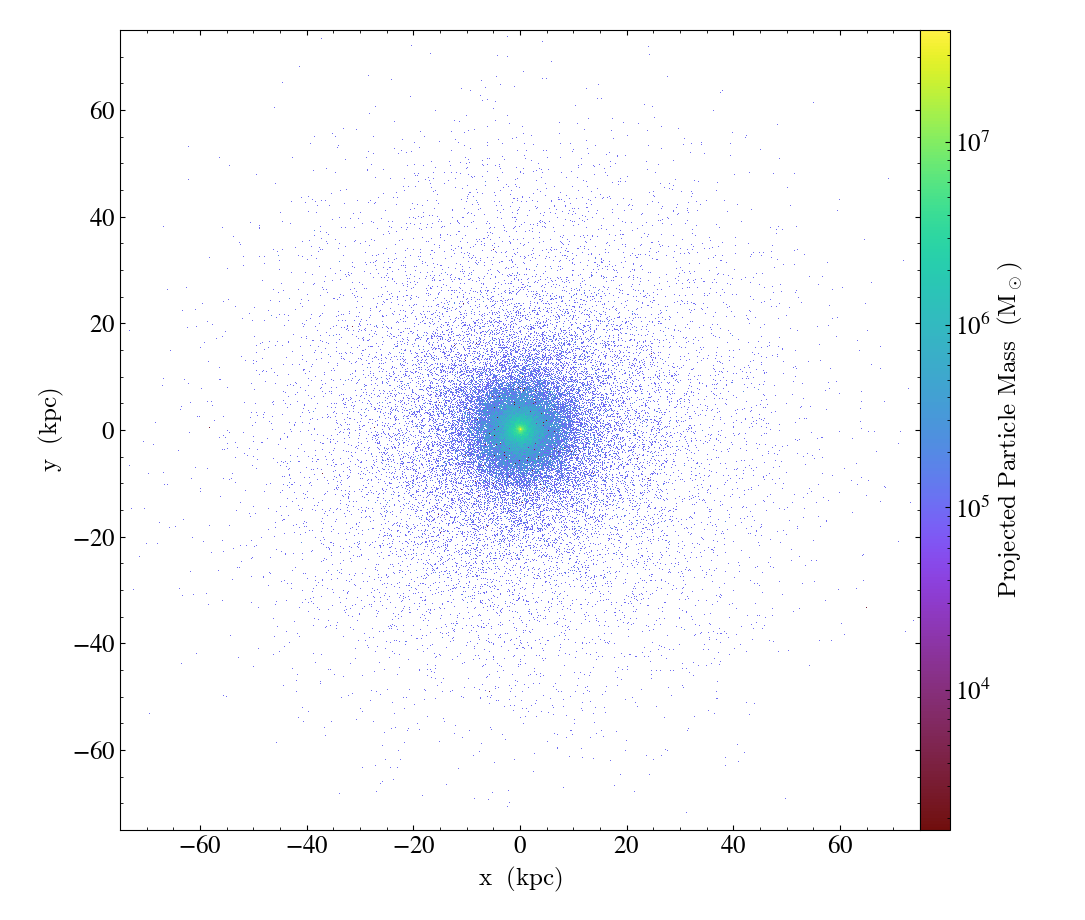

In [26]:
#Plot spatial distribution of stars projected along z
plot_stars = yt.ParticlePlot(ds, ("io", "particle_position_x"), ("io", "particle_position_y"), ("io", "particle_mass"), depth = 0.1)
                                 # First: x-axis, Second: y-axis, Third: projection (summing this value along normal), depth means you only take a thin layer

#plot_stars = yt.ParticleProjectionPlot(ds, 2, [("io", "particle_mass")], width=(0.5, 0.5), density=True)       Read about this one (density on ParticleProjectionPlot)
plot_stars.set_unit(("io", "particle_mass"), "Msun")
plot_stars.show()

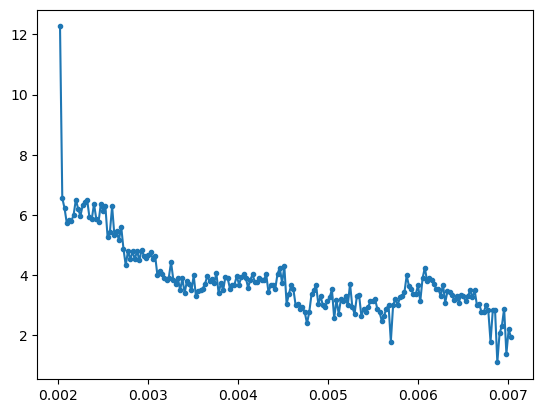

In [27]:
#PDF of metallicity
met = (ad[("io", "particle_metallicity")])
hist, bin_edges = np.histogram(met, bins = 200)
binc = (bin_edges[1:]+bin_edges[:1])/2
plt.plot(binc, np.log(hist), '.-')
plt.show()


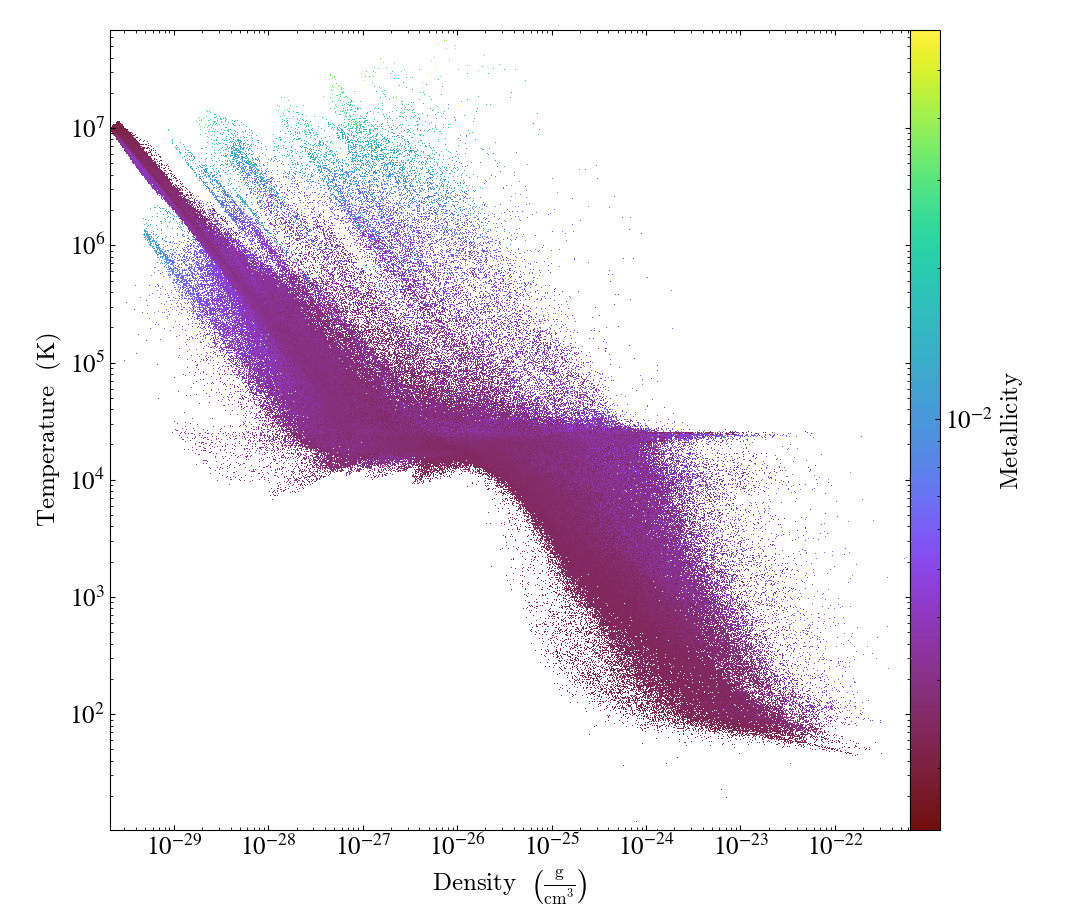

In [10]:
##      Another rather easy way to make a phase diagram showing certain quantities (metalllicity in this case)
##      as opposed just a 2d histogram
phase_stuffs = yt.create_profile(ad, [("gas", "density"), ("gas", "temperature")], ("gas", "metallicity"), n_bins=[1000, 1000])

plot = yt.PhasePlot.from_profile(phase_stuffs)
plot.set_zlim('metallicity', 1.5e-3, 6e-2)
plot.show()

In [30]:

T = ad[("gas", "temperature")]
rho = ad[('gas', 'density')]
posx = ad[('io', 'particle_position_x')].in_units('kpc')
posy = ad[('io', 'particle_position_y')].in_units('kpc')

In [31]:
met = ad[('io', 'particle_metallicity')]
posx = ad[('io', 'particle_position_x')].in_units('kpc')
posy = ad[('io', 'particle_position_y')].in_units('kpc')
ind_max_met = np.argmax(met)
offsetx = (np.max(posx)-np.min(posx))/2
offsety = (np.max(posy)-np.min(posy))/2
posx -= offsetx
posy -= offsety
print(np.min(posx))
print(np.max(posx), posy)

-74.95620707308507 kpc
74.95551688963697 kpc [-3.56781120e+01 -4.83346482e+01 -2.08028552e+01 ...  4.15971628e-02
 -6.73871913e+01 -6.56969931e+01] kpc


yt : [INFO     ] 2024-07-19 20:35:44,868 xlim = 0.000000 1.000000
yt : [INFO     ] 2024-07-19 20:35:44,873 ylim = 0.000000 1.000000
yt : [INFO     ] 2024-07-19 20:35:44,878 xlim = 0.000000 1.000000
yt : [INFO     ] 2024-07-19 20:35:44,880 ylim = 0.000000 1.000000
yt : [INFO     ] 2024-07-19 20:35:44,883 Making a fixed resolution buffer of (('gas', 'metallicity')) 800 by 800



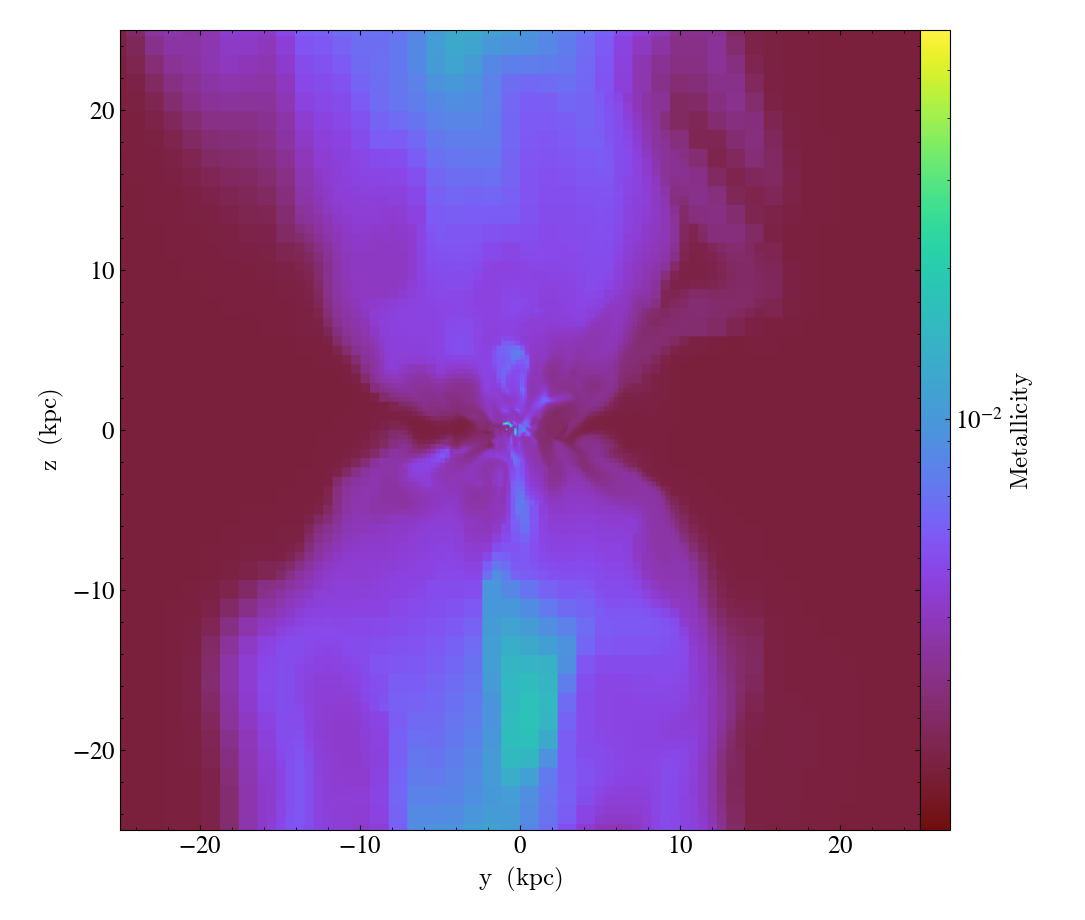

In [33]:
#Map of metallicity
plot_gas_met = yt.SlicePlot(ds, 'x', ("gas", "metallicity"))
plot_gas_met.zoom(3)
plot_gas_met.set_zlim('metallicity', 1.5e-3, 6e-2)
# plot_gas_met.annotate_quiver(
#    ("gas", "velocity_y"),
#    ("gas", "velocity_z"),
#    factor=10,
#    color="white")
plot_gas_met.show()


In [2]:
#Profile of metallicity
prof_met = yt.ProfilePlot(sp, ('index', 'radius'), ("gas", "metallicity"))
prof_met.set_unit((('index', 'radius')),'kpc')
prof_met.set_log((('index', 'radius')), False)
prof_met.show()

NameError: name 'yt' is not defined


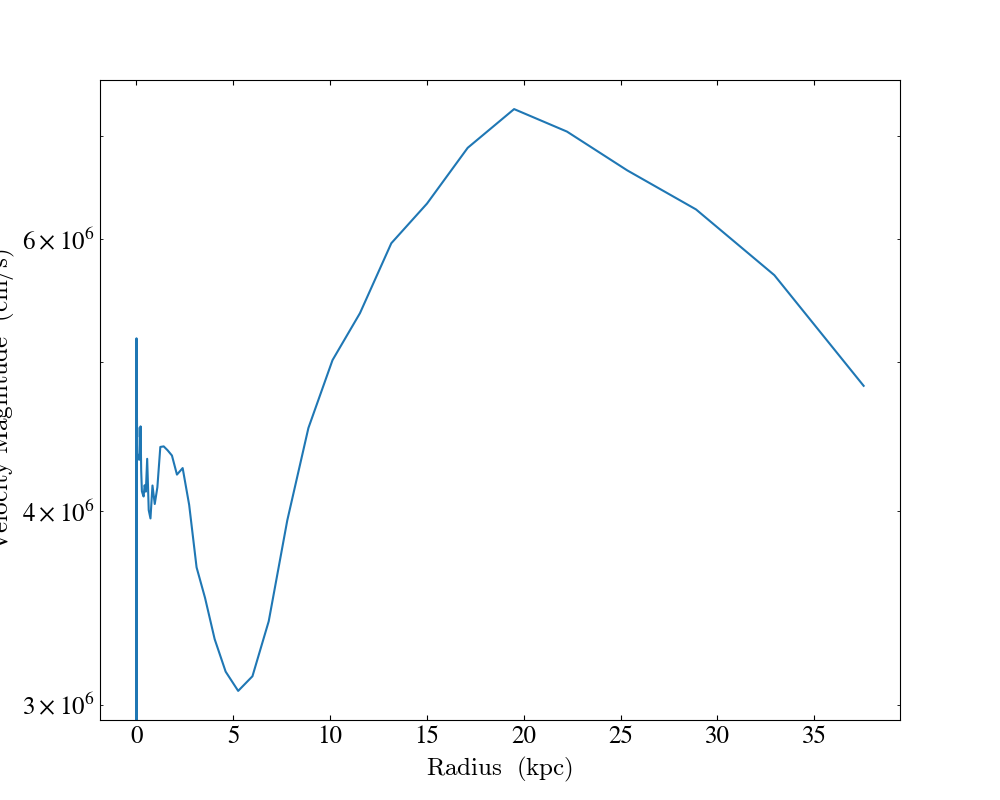

In [35]:
#Radial profile of speed
prof_vel = yt.ProfilePlot(sp, ('index', 'radius'), ("gas", "velocity_magnitude"))
prof_vel.set_unit((('index', 'radius')),'kpc')
prof_vel.set_log((('index', 'radius')), False)
prof_vel.show()


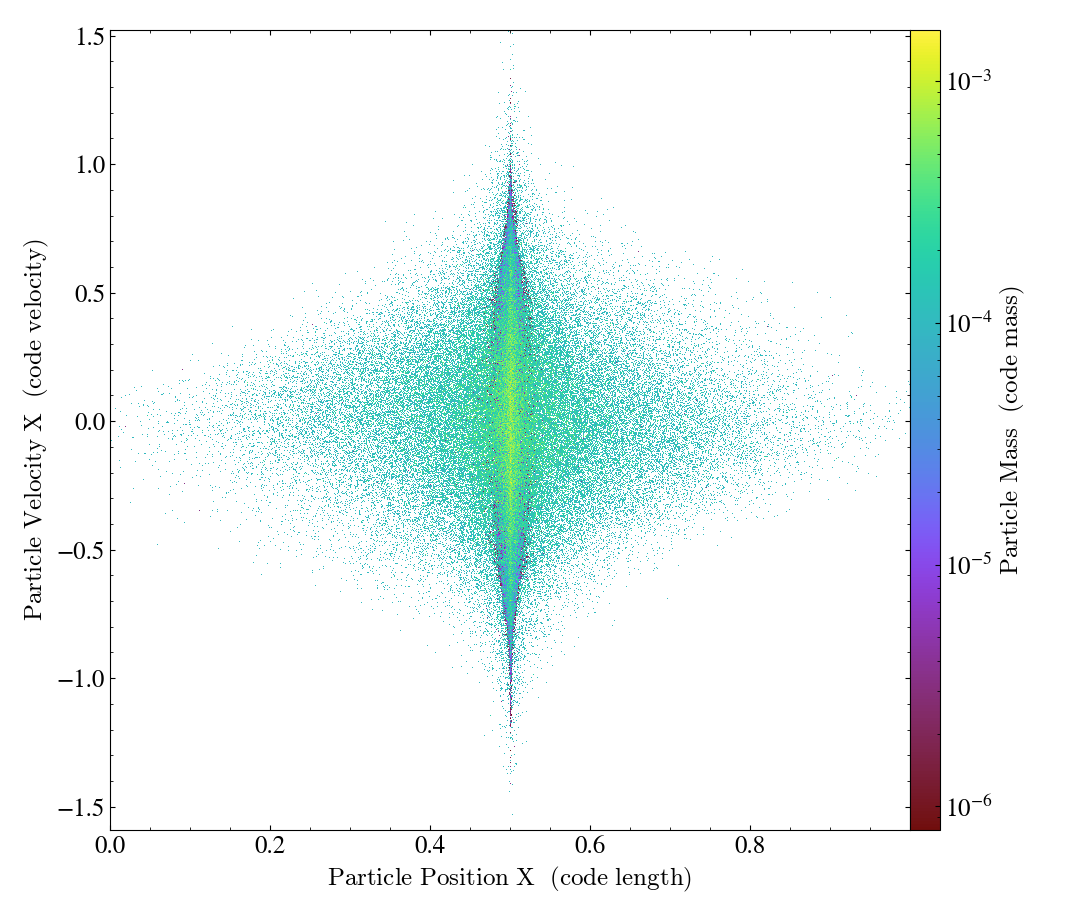

In [36]:
##  Phase space diagrams
plot_x_vx = yt.ParticlePlot(ds, ("io", 'particle_position_x'), ('io', 'particle_velocity_x'), ('io', 'particle_mass'))
plot_x_vx.show()

This next part tries to track the HI, HII, HeII, and HeIII fractions. Interesting HII and HeIII have big concentrations around the galaxy and low within. I assume this is due to ionization being easier in hotter regions?

HI and HeII on the other hand reside mainly in the centre, and the side-on view shows outflows, which I assume is from the same mechanism as the other outflows.

yt : [INFO     ] 2024-07-19 20:35:55,679 xlim = 0.000000 1.000000
yt : [INFO     ] 2024-07-19 20:35:55,680 ylim = 0.000000 1.000000
yt : [INFO     ] 2024-07-19 20:35:55,683 xlim = 0.000000 1.000000
yt : [INFO     ] 2024-07-19 20:35:55,684 ylim = 0.000000 1.000000
yt : [INFO     ] 2024-07-19 20:35:55,686 Making a fixed resolution buffer of (('ramses', 'xHI')) 800 by 800



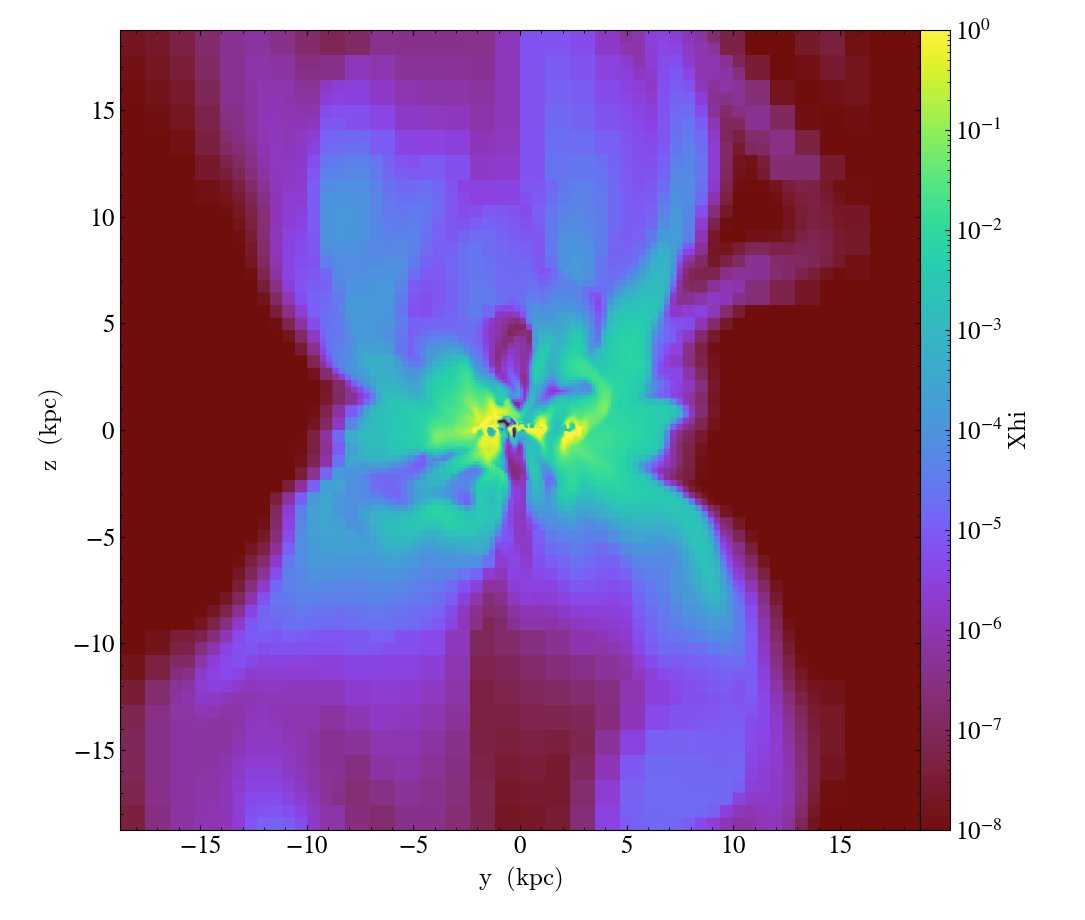

In [38]:
#Track HI
plot_HI = yt.SlicePlot(ds, 'x', ("ramses", "xHI"))
plot_HI.zoom(4)
plot_HI.set_zlim(("ramses", "xHI"), 1e-8, 1)
plot_HI.show()

yt : [INFO     ] 2024-07-19 20:35:57,218 xlim = 0.000000 1.000000
yt : [INFO     ] 2024-07-19 20:35:57,219 ylim = 0.000000 1.000000
yt : [INFO     ] 2024-07-19 20:35:57,222 xlim = 0.000000 1.000000
yt : [INFO     ] 2024-07-19 20:35:57,222 ylim = 0.000000 1.000000
yt : [INFO     ] 2024-07-19 20:35:57,223 Making a fixed resolution buffer of (('ramses', 'xHII')) 800 by 800



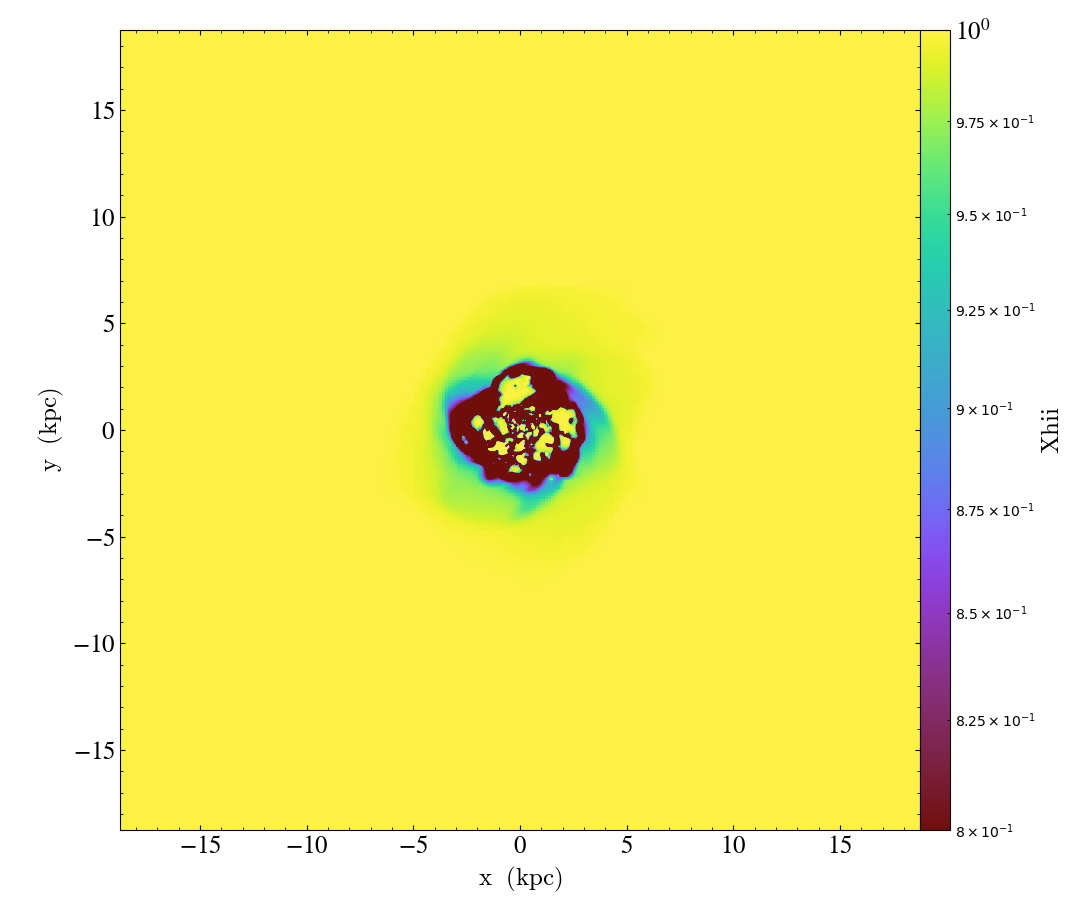

In [39]:
#Track HII
plot_HII = yt.SlicePlot(ds, 'z', ("ramses", "xHII"))
plot_HII.zoom(4)
plot_HII.set_zlim(("ramses", "xHII"), 8e-1, 1)
plot_HII.show()

In [40]:
#Track molecular H2
HI = ad[("ramses", "xHI")]
HII = ad[("ramses", "xHII")]
left = []
for i in range(len(HI)):
    left.append(1-HI[i]-HII[i])

yt : [INFO     ] 2024-07-19 20:38:03,347 xlim = 0.000000 1.000000
yt : [INFO     ] 2024-07-19 20:38:03,348 ylim = 0.000000 1.000000
yt : [INFO     ] 2024-07-19 20:38:03,357 xlim = 0.000000 1.000000
yt : [INFO     ] 2024-07-19 20:38:03,362 ylim = 0.000000 1.000000
yt : [INFO     ] 2024-07-19 20:38:03,364 Making a fixed resolution buffer of (('ramses', 'xHeII')) 800 by 800



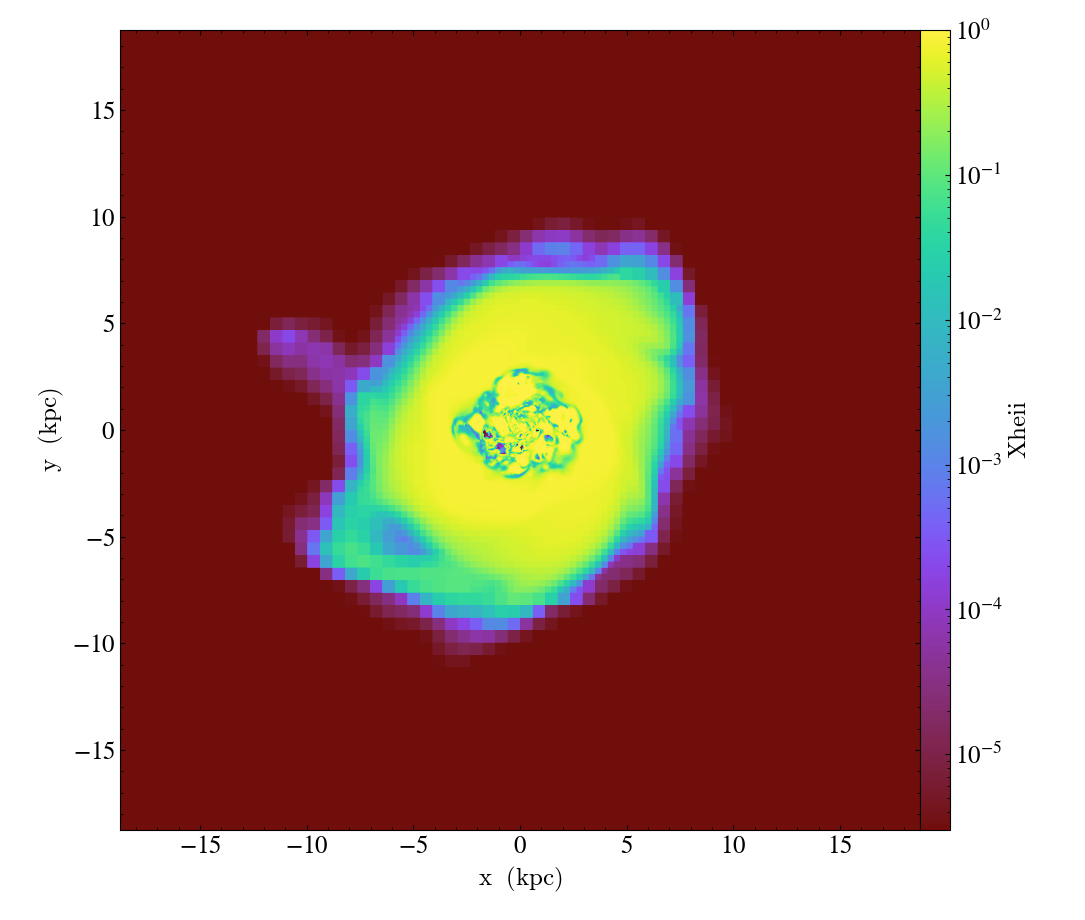

In [41]:
#Map of He II
plot_HeII = yt.SlicePlot(ds, 'z', ("ramses", "xHeII"))
plot_HeII.zoom(4)
plot_HeII.set_zlim(("ramses", "xHeII"), 3e-6, 1)
plot_HeII.show()

yt : [INFO     ] 2024-07-19 20:38:04,490 xlim = 0.000000 1.000000
yt : [INFO     ] 2024-07-19 20:38:04,493 ylim = 0.000000 1.000000
yt : [INFO     ] 2024-07-19 20:38:04,496 xlim = 0.000000 1.000000
yt : [INFO     ] 2024-07-19 20:38:04,498 ylim = 0.000000 1.000000
yt : [INFO     ] 2024-07-19 20:38:04,501 Making a fixed resolution buffer of (('ramses', 'xHeIII')) 800 by 800



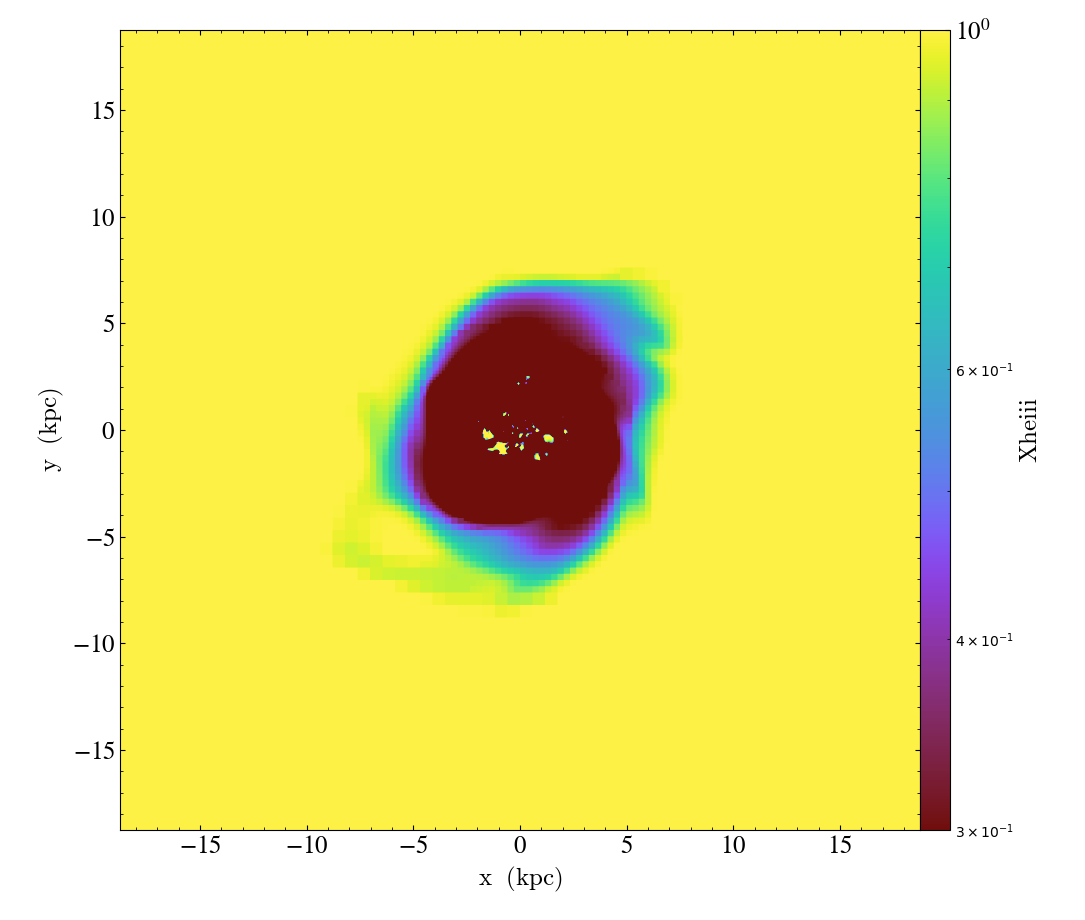

yt : [INFO     ] 2024-07-19 20:38:05,764 xlim = 0.000000 1.000000
yt : [INFO     ] 2024-07-19 20:38:05,774 ylim = 0.000000 1.000000
yt : [INFO     ] 2024-07-19 20:38:05,786 xlim = 0.000000 1.000000
yt : [INFO     ] 2024-07-19 20:38:05,786 ylim = 0.000000 1.000000
yt : [INFO     ] 2024-07-19 20:38:05,787 Making a fixed resolution buffer of (('gas', 'temperature')) 800 by 800



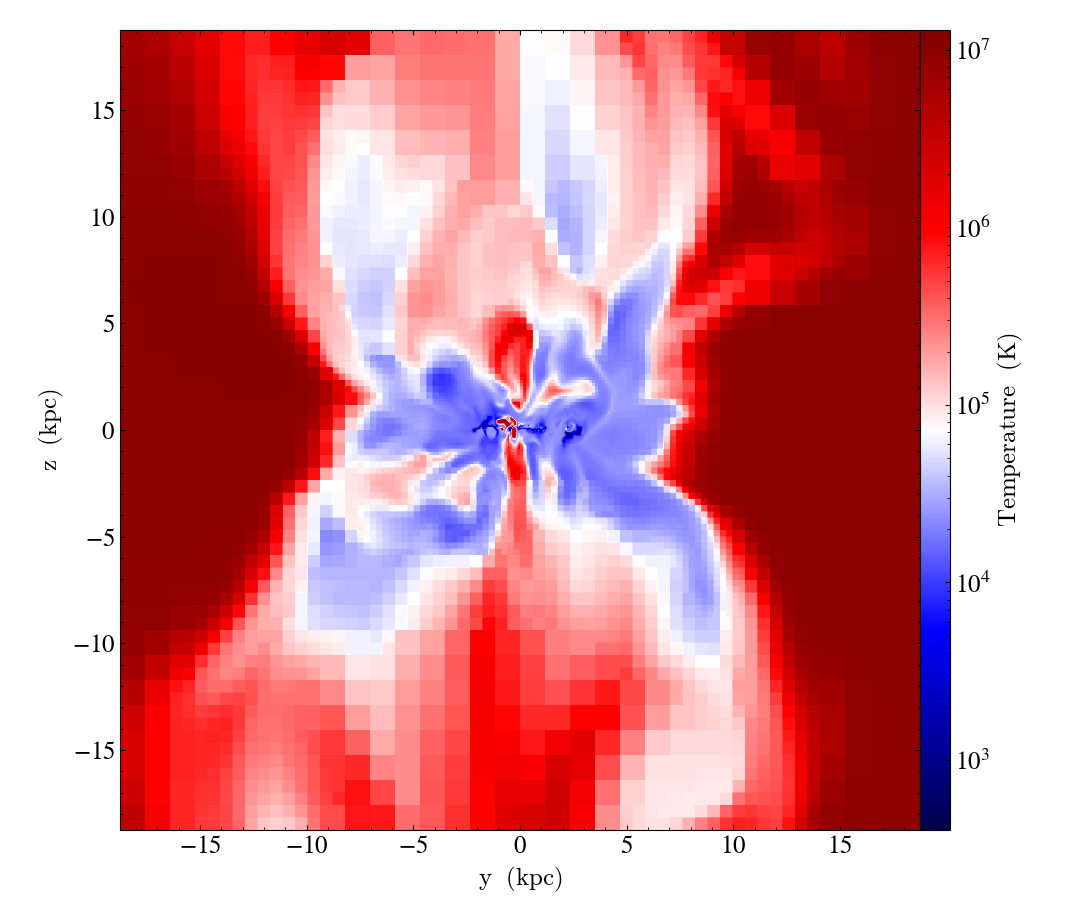

In [42]:
#Map of HeIII and temp
plot_HeIII = yt.SlicePlot(ds, 'z', ("ramses", "xHeIII"))
plot_HeIII.zoom(4)
plot_HeIII.set_zlim(("ramses", "xHeIII"), 3e-1, 1)
plot_HeIII.show()

slice_temperature = yt.SlicePlot(ds, 'x', ("gas", "temperature"))
slice_temperature.set_cmap(("gas", "temperature"), "seismic")
slice_temperature.zoom(4)
slice_temperature.show()

In [43]:
print(np.argmax(ad[("ramses", "xHII")]))

print((ad[("ramses", "xHII")])[463615]+(ad[("ramses", "xHI")])[463615])
print((ad[("ramses", "xHeII")])[463615]+(ad[("ramses", "xHeIII")])[463615])


738519
0.9999999999999996 dimensionless
0.9999999999998136 dimensionless


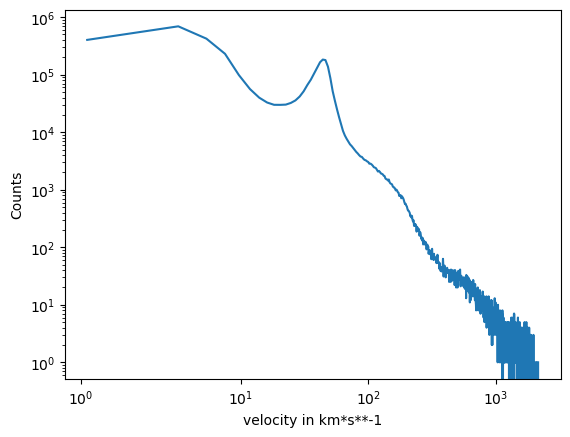

In [44]:
hist, bin_edges = np.histogram((ad[('gas', 'velocity_magnitude')]).in_units('km*s**-1'), bins = 1000)
bin_centers = (bin_edges[:-1]+bin_edges[1:])/2
plt.plot(bin_centers, hist)
#plt.xlim(0, 100)
plt.xscale('symlog')
plt.yscale('log')
plt.xlabel('velocity in km*s**-1')
plt.ylabel('Counts')
plt.show()

# hist, bin_edges = np.histogram((ad[('io', 'particle_velocity_magnitude')]), bins = 100)
# bin_centers = (bin_edges[:-1]+bin_edges[1:])/2
# plt.plot(bin_centers, hist)
# plt.show()

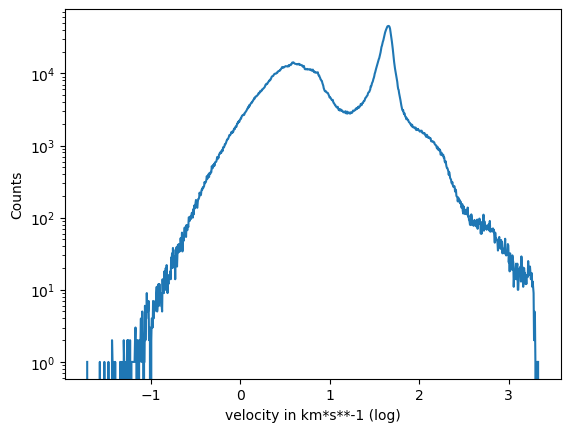

In [45]:
#PDF of speed
norm = np.log10((np.sqrt(ad[('gas', 'velocity_x')]**2 + ad[('gas', 'velocity_y')]**2 + ad[('gas', 'velocity_z')]**2))/(1e5))
hist, bin_edges = np.histogram(norm, bins = 1000)
bin_centers = (bin_edges[:-1]+bin_edges[1:])/2
plt.plot(bin_centers, hist)
#plt.xlim(0, 100)
#plt.xscale('symlog')
plt.yscale('log')
plt.xlabel('velocity in km*s**-1 (log)')
plt.ylabel('Counts')
plt.show()


R200 = 41.0959 #convert to code units !!!  ##length (code_length) = length(cm)/(boxlen*unit_l) from into_00xxx.txt  !!!

center_dat=[0.5, 0.5, 0.5]

[[c-rad_dat for c in center_dat], [c+rad_dat for c in center_dat]]

info_00203.txt

In [ ]:
1.268087e+23/(0.150000000000000E+03*0.308567758128200E+22)

0.2739726724728318

yt : [INFO     ] 2024-07-19 12:49:25,540 xlim = 0.000000 1.000000
yt : [INFO     ] 2024-07-19 12:49:25,540 ylim = 0.000000 1.000000
yt : [INFO     ] 2024-07-19 12:49:25,542 xlim = 0.000000 1.000000
yt : [INFO     ] 2024-07-19 12:49:25,543 ylim = 0.000000 1.000000
yt : [INFO     ] 2024-07-19 12:49:25,544 Making a fixed resolution buffer of (('gas', 'velocity_magnitude')) 800 by 800



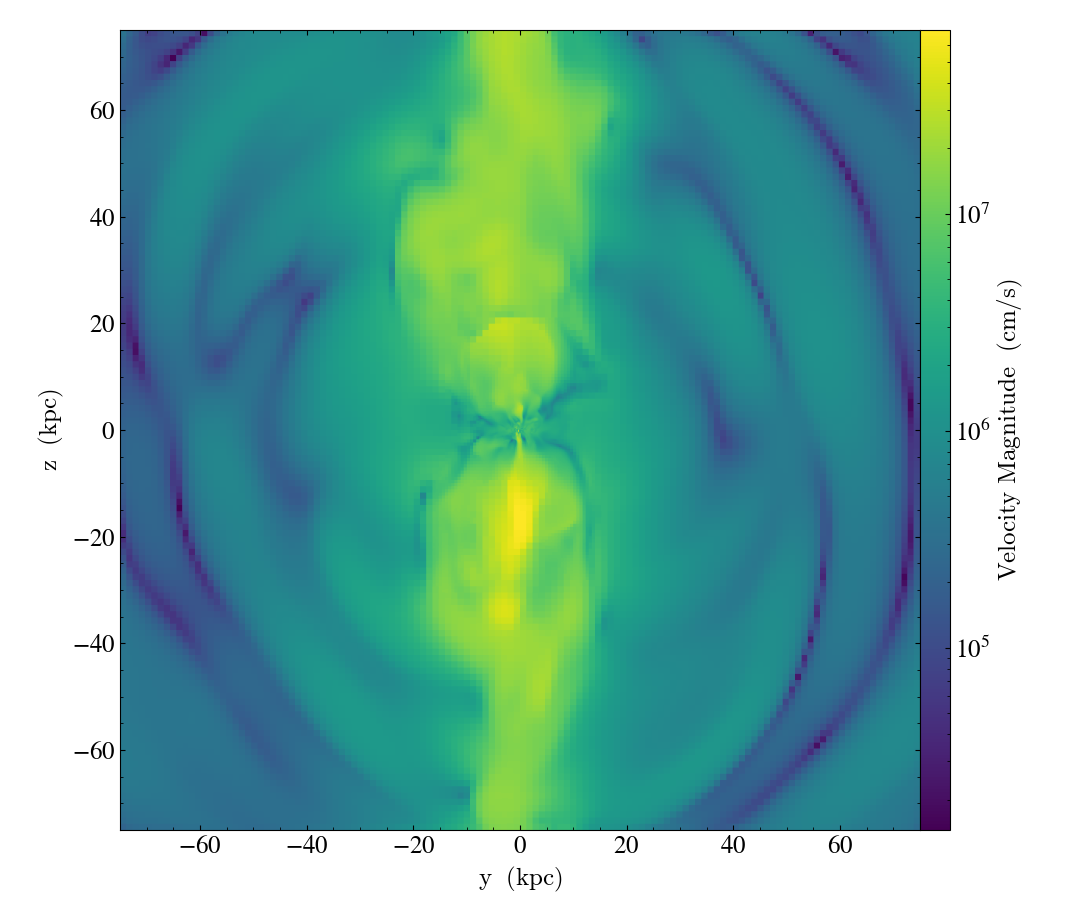

In [ ]:
#Map of speed
plot_vel = yt.SlicePlot(ds, 'x', ("gas", "velocity_magnitude"))
plot_vel.set_cmap(("gas", "velocity_magnitude"), "viridis")
plot_vel.zoom(1)
#plot_vel.set_zlim(("gas", "velocity_z"), -2e6, 7e6)
plot_vel.show()